# Load libraries

In [ ]:
import pandas as pd
import numpy as np
import random as rnd
import sklearn as skl
import seaborn as sn
import matplotlib.pyplot as plt
import pysqlite3 as sqlite3
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, auc, roc_curve, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from xgboost import XGBClassifier

import json
import warnings
from IPython.display import display, Math
from pickle import dump, load
import kagglehub

warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Download data using Kaggle API *"kagglehub"* and construct data frame

In [2]:
# Download latest version of the database from Kaggle and get the path to the dataset files
path = kagglehub.dataset_download("chetanmittal033/credit-card-fraud-data")
print("Path to dataset files:", path)

Path to dataset files: /Users/csmb/.cache/kagglehub/datasets/chetanmittal033/credit-card-fraud-data/versions/1


In [3]:
# Set dataframe for data analysis
path_to_fraud_csv  = path + "/fraudTest.csv"
dfFraudCC  = pd.read_csv(path_to_fraud_csv)
dfFraudCC['cc_num'] = dfFraudCC['cc_num'].astype(int)

# Database generation with SQLite

In [ ]:
# Create a connection to the SQLite database and load the data into a DataFrame
conn = sqlite3.connect('/workspaces/final-project-csmb20/data/databases/credit_card_fraud.db')
dfFraudCC.to_sql('credit_card_fraud_data', conn, if_exists='replace', index=False)

# Delete sn column from database
cursor = conn.cursor()

# Drop the 'sn' column since it is not relevant for our analysis
cursor.execute("ALTER TABLE credit_card_fraud_data DROP COLUMN sn")

# Rename some columns for better readability
cursor.execute("ALTER TABLE credit_card_fraud_data RENAME COLUMN dob TO date_of_birth")
cursor.execute("ALTER TABLE credit_card_fraud_data RENAME COLUMN first TO first_name")
cursor.execute("ALTER TABLE credit_card_fraud_data RENAME COLUMN last TO last_name")
cursor.execute("ALTER TABLE credit_card_fraud_data RENAME COLUMN amt TO transaction_amount")
cursor.execute("ALTER TABLE credit_card_fraud_data RENAME COLUMN street TO address")

# Separate date and time into separate columns
cursor.execute("ALTER TABLE credit_card_fraud_data ADD COLUMN trans_date TEXT")
cursor.execute("UPDATE credit_card_fraud_data SET trans_date = substr(trans_date_trans_time, 1, 10)")
cursor.execute("ALTER TABLE credit_card_fraud_data ADD COLUMN trans_time TIME AS (TIME(SUBSTR(trans_date_trans_time, 12)))")

# Add columns based on category (online or face-to-face purchase)
cursor.execute("ALTER TABLE credit_card_fraud_data ADD COLUMN online_purchase INTEGER")
cursor.execute("UPDATE credit_card_fraud_data SET online_purchase = CASE WHEN category LIKE '%_pos%' THEN 0 WHEN category LIKE '%_net%' THEN 1 ELSE 2 END")

# Insert a new column for the age of the cardholder at the time of the transaction
cursor.execute("ALTER TABLE credit_card_fraud_data" \
               " ADD COLUMN age FLOAT" \
               " AS (CAST((JULIANDAY(substr(trans_date, 7, 4) || '-' || substr(trans_date, 4, 2) || '-' || substr(trans_date, 1, 2)) - JULIANDAY(substr(date_of_birth, 7, 4) || '-' || substr(date_of_birth, 4, 2) || '-' || substr(date_of_birth, 1, 2))) / 365.25 AS FLOAT))")


In [5]:
# Reorder the columns to have a more logical structure
cursor.execute("DROP TABLE IF EXISTS credit_card_fraud_data_new")
cursor.execute("ALTER TABLE credit_card_fraud_data RENAME TO credit_card_fraud_data_temporary")
cursor.execute("CREATE TABLE credit_card_fraud_data_new(" \
                " cc_num INTEGER," \
                " first_name TEXT," \
                " last_name TEXT," \
                " gender TEXT," \
                " date_of_birth TEXT," \
                " age FLOAT," \
                " job TEXT," \
                " trans_date TEXT," \
                " trans_time TEXT," \
                " transaction_amount FLOAT," \
                " category TEXT," \
                " address TEXT," \
                " city TEXT," \
                " city_pop INTEGER," \
                " state TEXT," \
                " zip INTEGER," \
                " lat FLOAT," \
                " long FLOAT," \
                " merchant TEXT," \
                " merch_lat FLOAT," \
                " merch_long FLOAT," \
                " trans_num INTEGER," \
                " unix_time INTEGER," \
                " is_fraud INTEGER," \
                " online_purchase INTEGER)")

cursor.execute("INSERT INTO credit_card_fraud_data_new SELECT cc_num, first_name, last_name, gender, date_of_birth, age, job, trans_date, trans_time, transaction_amount, category, address, city, city_pop, state, zip, lat, long, merchant, merch_lat, merch_long, trans_num, unix_time, is_fraud, online_purchase " \
               "FROM credit_card_fraud_data_temporary")

# Drop the temporary table
cursor.execute("DROP TABLE credit_card_fraud_data_temporary")

# Commit the changes and close the connection
conn.commit()

In [6]:
# Perform some basic analysis on the data to evaluate data quality and get insights

# Group the data by state and verify the number of fraudulent transactions in each state
#df_fraud_by_state = pd.read_sql_query("SELECT state, COUNT(*) AS fraud_count FROM credit_card_fraud_data_new WHERE is_fraud = 1 GROUP BY state ORDER BY fraud_count DESC", conn)
#display(df_fraud_by_state)

# Group the data by state and verify the number of fraudulent transactions in each state
#df_fraud_by_gender = pd.read_sql_query("SELECT gender, COUNT(*) AS fraud_count FROM credit_card_fraud_data_new WHERE is_fraud = 1 GROUP BY gender ORDER BY fraud_count DESC", conn)
#display(df_fraud_by_gender)

# Average transaction amount for fraudulent transactions
#df_avg_fraud_amount = pd.read_sql_query("SELECT AVG(transaction_amount) AS avg_fraud_amount FROM credit_card_fraud_data_new WHERE is_fraud = 1", conn)
#display(df_avg_fraud_amount)

# Median age of cardholders involved in fraudulent transactions
#df_median_age_fraud = pd.read_sql_query("SELECT AVG(age) AS median_age_fraud FROM (SELECT age FROM credit_card_fraud_data_new WHERE is_fraud = 1 ORDER BY age" \
#                                        " LIMIT 2 - (SELECT COUNT(*) FROM credit_card_fraud_data_new WHERE is_fraud = 1) % 2" \
#                                        " OFFSET ((SELECT COUNT(*) FROM credit_card_fraud_data_new WHERE is_fraud = 1) - 1) / 2)", conn)
#display(df_median_age_fraud)

In [7]:
# Get new dataframe for analysis from database
df_FraudCC_new = pd.read_sql_query("SELECT * FROM credit_card_fraud_data_new", conn)

# Close the database connection
conn.close()

# Data frame inspection

In [8]:
# Data inspection

print(f'Raw data frame shape: {df_FraudCC_new.shape}')
print(df_FraudCC_new.info())

# Verify duplicates, NANs, and infinite values

if df_FraudCC_new.duplicated().any().any():
    df_FraudCC_new = df_FraudCC_new.drop_duplicates()
    print(f'Data frame shape after dropping duplicates: {df_FraudCC_new.shape}')

df_FraudCC_new.replace([np.inf, -np.inf], np.nan, inplace=True)
if df_FraudCC_new.isna().any().any():
    df_FraudCC_new = df_FraudCC_new.dropna()
    print(f'Data frame shape after dropping NA: {df_FraudCC_new.shape}')

Raw data frame shape: (555719, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   cc_num              555719 non-null  int64  
 1   first_name          555719 non-null  object 
 2   last_name           555719 non-null  object 
 3   gender              555719 non-null  object 
 4   date_of_birth       555719 non-null  object 
 5   age                 555719 non-null  float64
 6   job                 555719 non-null  object 
 7   trans_date          555719 non-null  object 
 8   trans_time          555719 non-null  object 
 9   transaction_amount  555719 non-null  float64
 10  category            555719 non-null  object 
 11  address             555719 non-null  object 
 12  city                555719 non-null  object 
 13  city_pop            555719 non-null  int64  
 14  state               555719 non-null  object 
 15 

In [9]:
# Remove columns that are not relevant for the analysis
columns_to_drop = ['first_name', 'last_name', 'date_of_birth', 'address', 'trans_num', 'unix_time'] # 'lat', 'long', 'merch_lat', 'merch_long' --- IGNORE ---
df_FraudCC_new_reduced = df_FraudCC_new.drop(columns=columns_to_drop)
print(f'Data frame shape after dropping irrelevant columns: {df_FraudCC_new_reduced.shape}')

Data frame shape after dropping irrelevant columns: (555716, 19)


## Encoding categories

In [10]:
# Let us encode categorical variables for machine learning models
label_encoder = LabelEncoder()

# Encoding gender
df_FraudCC_new_reduced['gender'] = label_encoder.fit_transform(df_FraudCC_new['gender'])
gender_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Encoding job
df_FraudCC_new_reduced['job'] = label_encoder.fit_transform(df_FraudCC_new['job'])
job_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Encoding category
df_FraudCC_new_reduced['category'] = label_encoder.fit_transform(df_FraudCC_new['category'])
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Encoding state
df_FraudCC_new_reduced['state'] = label_encoder.fit_transform(df_FraudCC_new['state'])
state_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Encoding merchant
df_FraudCC_new_reduced['merchant'] = label_encoder.fit_transform(df_FraudCC_new['merchant'])
merchant_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Encoding city
df_FraudCC_new_reduced['city'] = label_encoder.fit_transform(df_FraudCC_new['city'])
city_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [ ]:
## Save dictionary in JSON format

city_state_data = (
    df_FraudCC_new
    .groupby("state")["city"]
    .unique()
    .apply(list)
    .to_dict()
)

city_pop_data = (
    df_FraudCC_new
    .groupby("city")["city_pop"]
    .unique()
    .apply(list)
    .to_dict()
)

city_lat_data = (
    df_FraudCC_new
    .groupby("city")["lat"]
    .unique()
    .apply(list)
    .to_dict()
)

city_long_data = (
    df_FraudCC_new
    .groupby("city")["long"]
    .unique()
    .apply(list)
    .to_dict()
)

with open('json_city_state_mapping.json', 'w') as cs:
    json.dump(city_state_data, cs)

with open('json_city_pop_mapping.json', 'w') as cp:
    json.dump(city_pop_data, cp, default=int) 

with open('json_city_lat_mapping.json', 'w') as la:
    json.dump(city_lat_data, la, default=float)  

with open('json_city_long_mapping.json', 'w') as lo:
    json.dump(city_long_data, lo, default=float)       

with open('json_city_mapping.json', 'w') as c:
    json.dump(city_mapping, c, default=int)

with open('json_state_mapping.json', 'w') as s:
    json.dump(state_mapping, s, default=int)

with open('json_merchant_mapping.json', 'w') as m:
    json.dump(merchant_mapping, m, default=int)    

## Slicing dates and times into days, months, years, hours, minutes, and seconds

In [12]:
# Include a new column for the transaction day, month, and year
df_FraudCC_new_reduced.insert(loc=5, column='trans_day', value=df_FraudCC_new_reduced['trans_date'].str.slice(0, 2).astype(int))
df_FraudCC_new_reduced.insert(loc=6, column='trans_month', value=df_FraudCC_new_reduced['trans_date'].str.slice(3, 5).astype(int))
df_FraudCC_new_reduced.insert(loc=7, column='trans_year', value=df_FraudCC_new_reduced['trans_date'].str.slice(6, 10).astype(int))

# Include a new column for the transaction hour, minute, and second
df_FraudCC_new_reduced.insert(loc=9, column='trans_hour', value=df_FraudCC_new_reduced['trans_time'].str.slice(0, 2).astype(int))
df_FraudCC_new_reduced.insert(loc=10, column='trans_minute', value=df_FraudCC_new_reduced['trans_time'].str.slice(3, 5).astype(int))
df_FraudCC_new_reduced.insert(loc=11, column='trans_second', value=df_FraudCC_new_reduced['trans_time'].str.slice(6, 8).astype(int))

# Exploratory Data Analysis (EDA)

In [188]:
# Check whether the distribution of fraudulent transaction amounts is skewed or if there are any outliers that may require further investigation or data cleaning
df_FraudCC_new_reduced['is_fraud'].value_counts()
data_max = df_FraudCC_new_reduced.max()
data_min = df_FraudCC_new_reduced.min()

In [191]:
data_max

cc_num                4992350000000000000
gender                                  1
age                                96.170
job                                   477
trans_date                     31-12-2020
trans_day                              31
trans_month                            12
trans_year                           2020
trans_time                       23:59:00
trans_hour                             23
trans_minute                           59
trans_second                            0
transaction_amount             22,768.110
category                               13
city                                  848
city_pop                          2906700
state                                  49
zip                                 99921
lat                                65.690
long                              -67.950
merchant                              692
merch_lat                          66.679
merch_long                        -66.952
is_fraud                          

Since the data is extremely imbalanced with a very small percentage of fraudulent transactions, we will resort to undersampling the data set to create a more 
balanced dataset for training our machine learning model. This will help improve the model's ability to learn patterns associated with fraudulent transactions 
and reduce bias towards the majority class.

In [14]:
# Save some fraud data for robustness test
indices0 = df_FraudCC_new_reduced.index[df_FraudCC_new_reduced['is_fraud'] == 0].tolist()
indices1 = df_FraudCC_new_reduced.index[df_FraudCC_new_reduced['is_fraud'] == 1].tolist()

n1 = int(0.95*len(indices1)) # Take 95 % of fraud data
indices1_model  = rnd.sample(indices1, n1) # Data used to develop model

# Balancing the dataset by downsampling
n0 = int(0.8/(1-0.8)*n1) # Number of elements to pick (75 % - 25 %) 

# Select n unique random numbers
indices0_model = rnd.sample(indices0, n0)
indices_total  = np.concatenate((indices0_model, indices1_model))
indices_total.sort()
df_FraudCC_new_balanced = df_FraudCC_new_reduced.loc[indices_total].copy().reset_index(drop=True)
df_FraudCC_new_balanced['is_fraud'].value_counts()

is_fraud
0    8148
1    2037
Name: count, dtype: int64

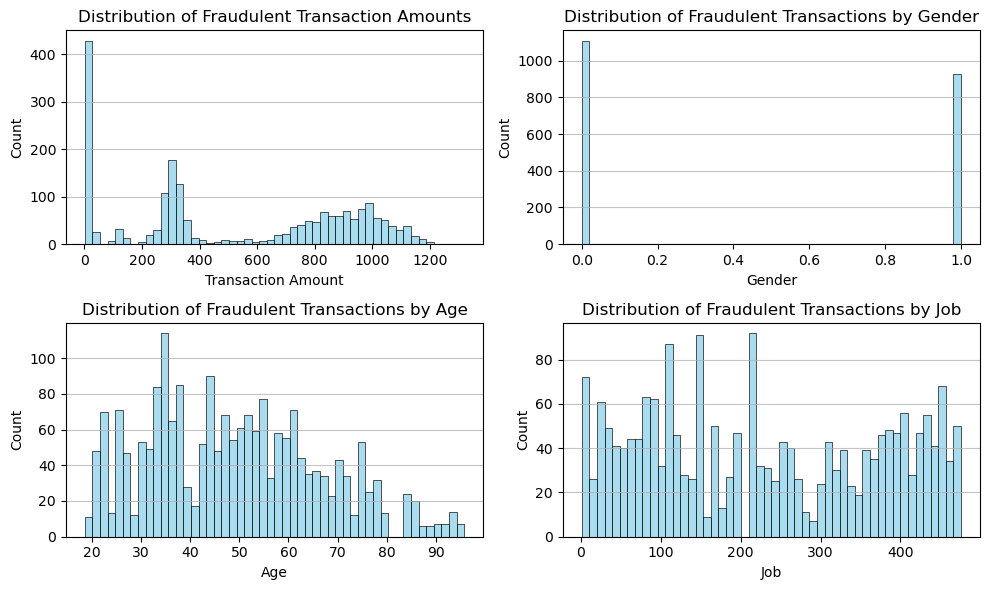

In [15]:
# Create histogram to understand the distributions and identify any patterns or anomalies

fig, ax = plt.subplots(2,2,figsize=(10, 6))

# Transaction amount distribution for fraudulent transactions
sn.histplot(df_FraudCC_new_balanced[df_FraudCC_new_balanced['is_fraud'] == 1]['transaction_amount'], kde = False, stat='count', bins=50, color='skyblue', alpha=0.7, ax=ax[0,0])
#sn.kdeplot(df_FraudCC_new_balanced[df_FraudCC_new_balanced['is_fraud'] == 1]['transaction_amount'], color='red', linewidth=2.5, label='PDF Line',ax=ax[0,0])
ax[0,0].set_title('Distribution of Fraudulent Transaction Amounts')
ax[0,0].set_xlabel('Transaction Amount')
ax[0,0].set_ylabel('Count')
ax[0,0].grid(axis='y', alpha=0.75)

# Gender distribution for fraudulent transactions
sn.histplot(df_FraudCC_new_balanced[df_FraudCC_new_balanced['is_fraud'] == 1]['gender'], kde = False, stat='count', bins=50, color='skyblue', alpha=0.7, ax=ax[0,1])
#sn.kdeplot(df_FraudCC_new_balanced[df_FraudCC_new_balanced['is_fraud'] == 1]['gender'], color='red', linewidth=2.5, label='PDF Line',ax=ax[0,1])
ax[0,1].set_title('Distribution of Fraudulent Transactions by Gender')
ax[0,1].set_xlabel('Gender')
ax[0,1].set_ylabel('Count')
ax[0,1].grid(axis='y', alpha=0.75)

# Age distribution for fraudulent transactions

sn.histplot(df_FraudCC_new_balanced[df_FraudCC_new_balanced['is_fraud'] == 1]['age'], kde = False, stat='count', bins=50, color='skyblue', alpha=0.7, ax=ax[1,0])
#sn.kdeplot(df_FraudCC_new_balanced[df_FraudCC_new_balanced['is_fraud'] == 1]['age'], color='red', linewidth=2.5, label='PDF Line',ax=ax[1,0])
ax[1,0].set_title('Distribution of Fraudulent Transactions by Age')
ax[1,0].set_xlabel('Age')
ax[1,0].set_ylabel('Count')
ax[1,0].grid(axis='y', alpha=0.75)

# Job distribution for fraudulent transactions
sn.histplot(df_FraudCC_new_balanced[df_FraudCC_new_balanced['is_fraud'] == 1]['job'], kde = False, stat='count', bins=50, color='skyblue', alpha=0.7, ax=ax[1,1])
#sn.kdeplot(df_FraudCC_new_balanced[df_FraudCC_new_balanced['is_fraud'] == 1]['job'], color='red', linewidth=2.5, label='PDF Line',ax=ax[1,1])
ax[1,1].set_title('Distribution of Fraudulent Transactions by Job')
ax[1,1].set_xlabel('Job')
ax[1,1].set_ylabel('Count')
ax[1,1].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

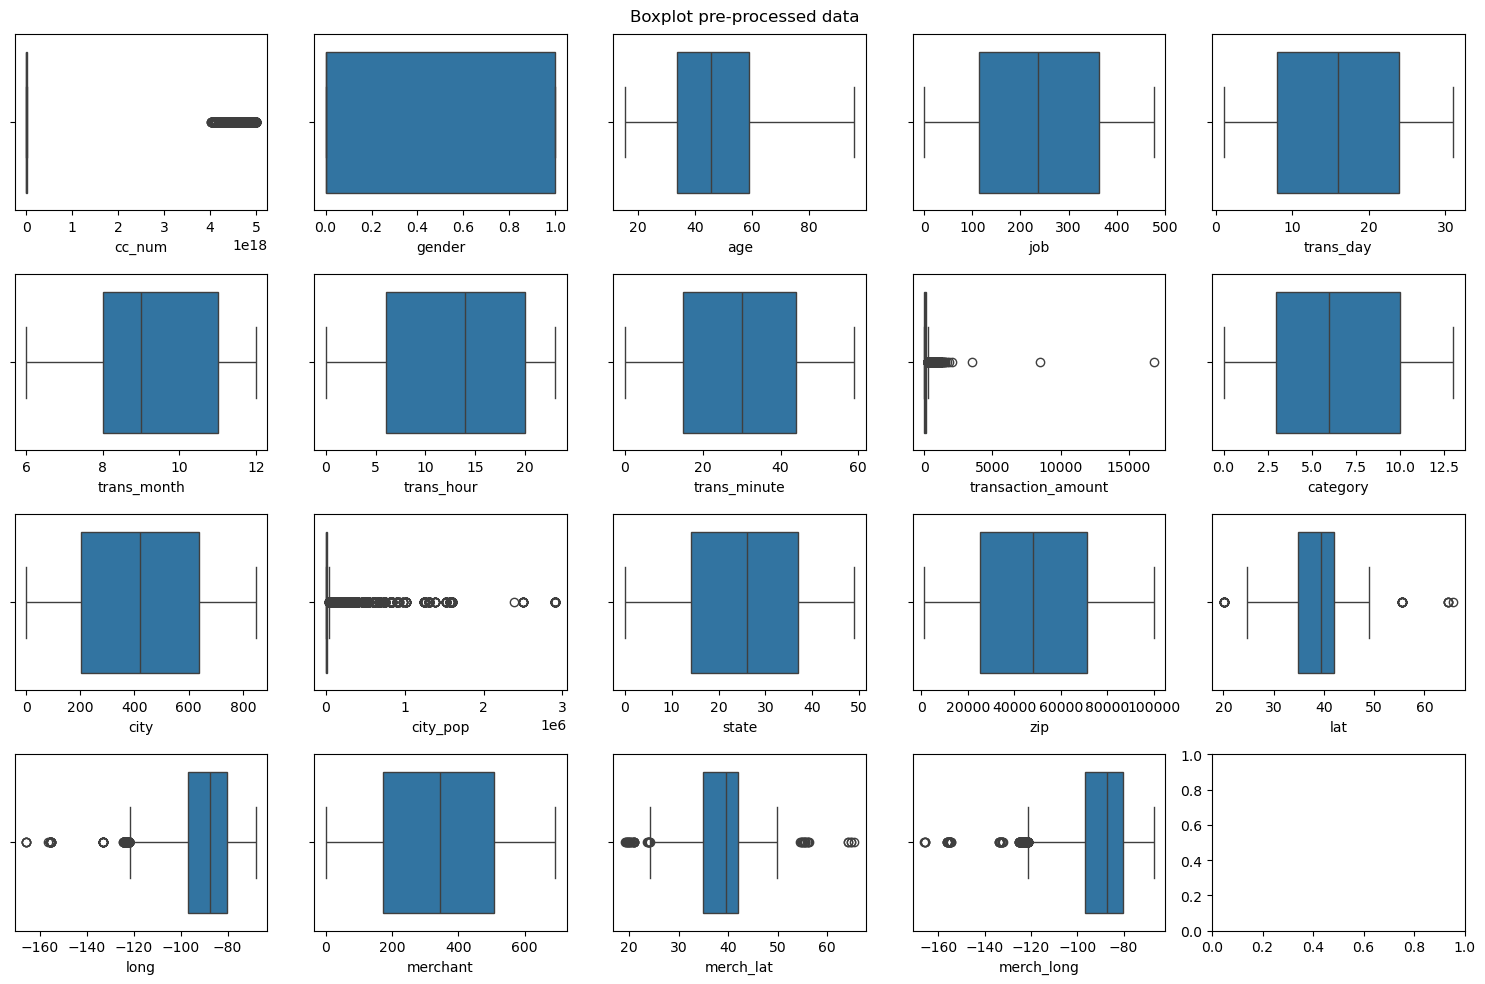

In [16]:
# Exploratory data analysis

# Get column list for boxplot
column_list = df_FraudCC_new_balanced.columns.tolist()
column_list.remove('trans_date')
column_list.remove('trans_year')
column_list.remove('trans_time')
column_list.remove('trans_second')
column_list.remove('is_fraud')
column_list.remove('online_purchase')

# Get outliers
fig, axis = plt.subplots(4,5,figsize=(15,10))
r = 0
c = 0
for col_idx in column_list:
    sn.boxplot(ax=axis[r,c], data = df_FraudCC_new_balanced, x = df_FraudCC_new_balanced[col_idx])
    c += 1
    if c > 4:
        r += 1
        c = 0

plt.suptitle('Boxplot pre-processed data')
plt.tight_layout()
plt.show()

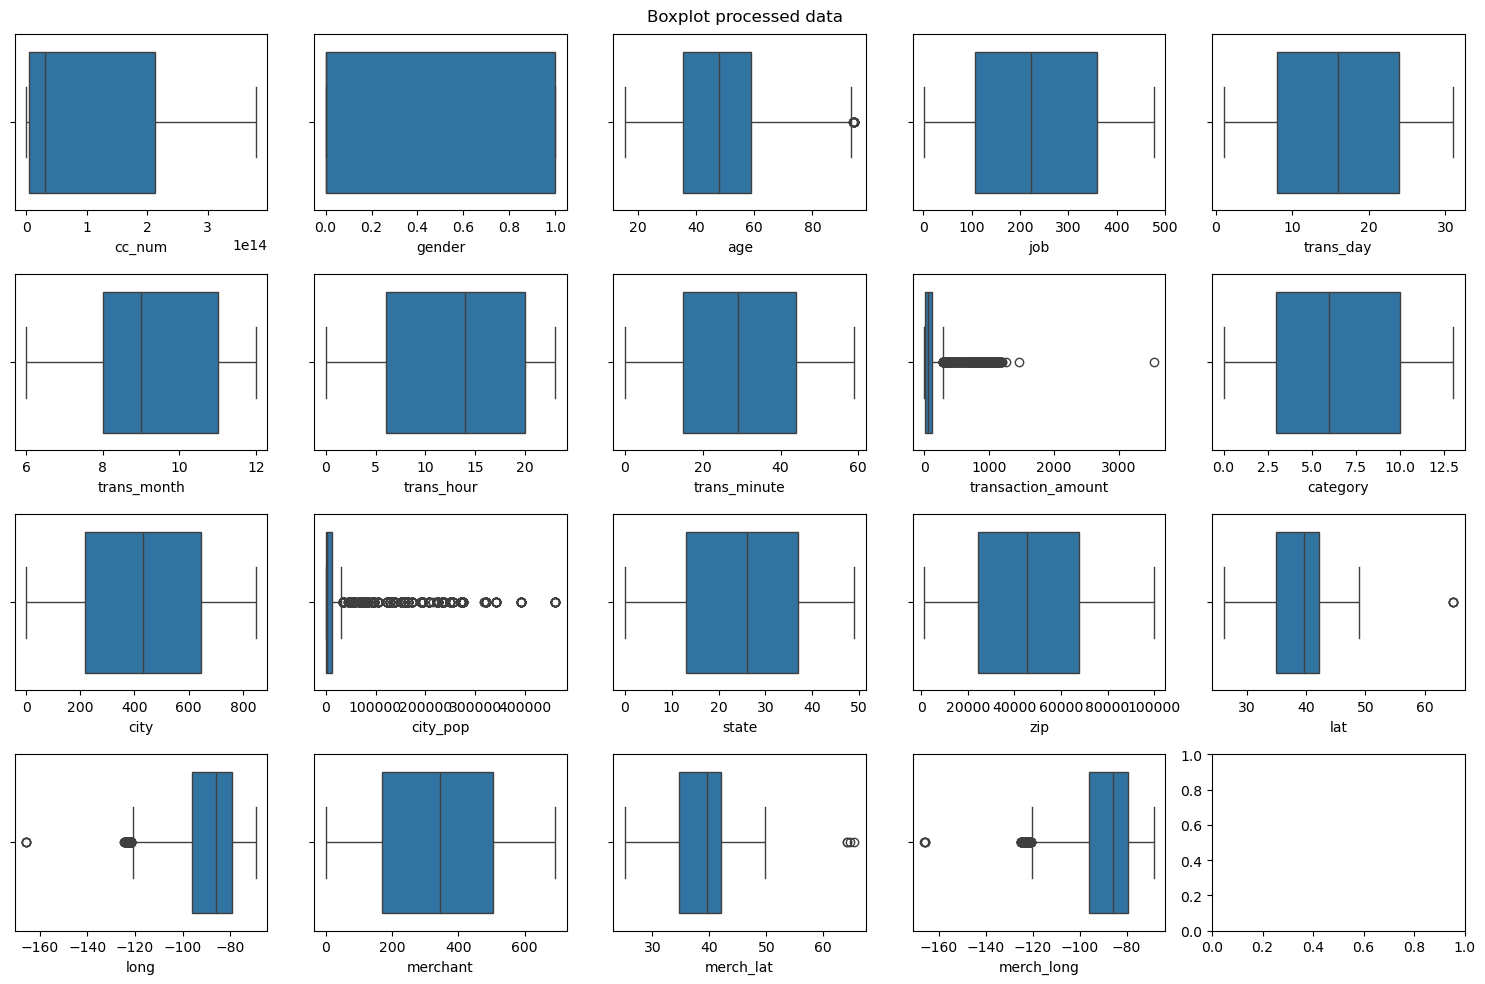

In [17]:
# Remove some of the outliers

df_FraudCC_new_balanced = df_FraudCC_new_balanced[df_FraudCC_new_balanced['cc_num'] <= 1e15]
df_FraudCC_new_balanced = df_FraudCC_new_balanced[df_FraudCC_new_balanced['transaction_amount'] <= 4500]
df_FraudCC_new_balanced = df_FraudCC_new_balanced[df_FraudCC_new_balanced['city_pop'] <= 500000]

# Get outliers
fig, axis = plt.subplots(4,5,figsize=(15,10))
r = 0
c = 0
for col_idx in column_list:
    sn.boxplot(ax=axis[r,c], data = df_FraudCC_new_balanced, x = df_FraudCC_new_balanced[col_idx])
    c += 1
    if c > 4:
        r += 1
        c = 0

plt.suptitle('Boxplot processed data')
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

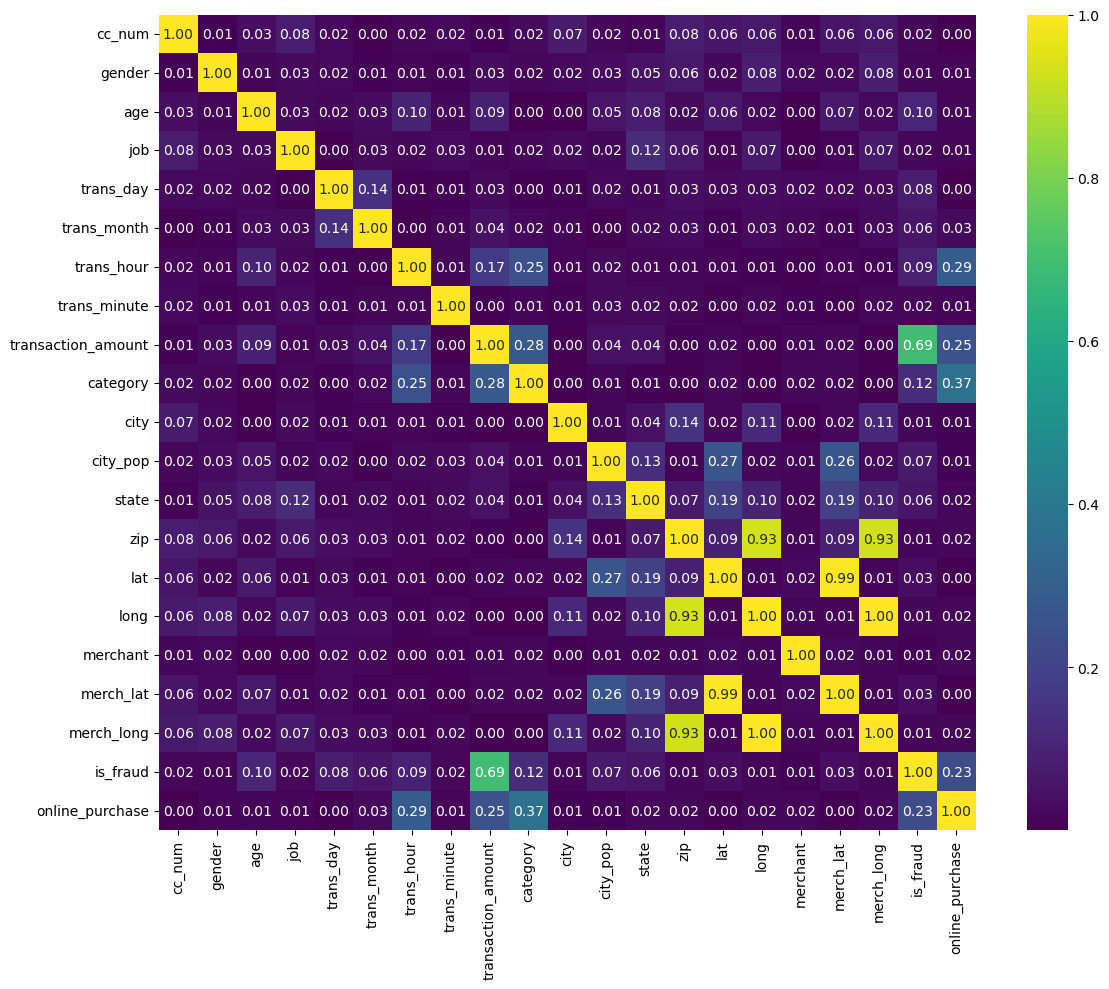

In [18]:
# Correlation heatmap

if 'is_fraud' not in column_list:
    column_list.append('is_fraud')

if 'online_purchase' not in column_list:
    column_list.append('online_purchase')    
    
plt.figure(figsize=(12,10))
fig, ax = plt.subplots(figsize=(12,10))
sn.heatmap(df_FraudCC_new_balanced[column_list].corr(method="pearson").abs(), annot=True, fmt=".2f", cmap="viridis", ax=ax)
plt.tight_layout()
plt.show()

The correlation analysis showed that only the feature *transaction amount* has a **linear** influence on the target variable *is_fraud*. The other variables show little linear correlation and may exhibit nonlinear relationships with the target variable. We shall analyse this checking scatterplots of the relevant features.

Optimization terminated successfully.
         Current function value: 0.574733
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.525263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.523602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.422382
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.538730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.435868
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592392
  

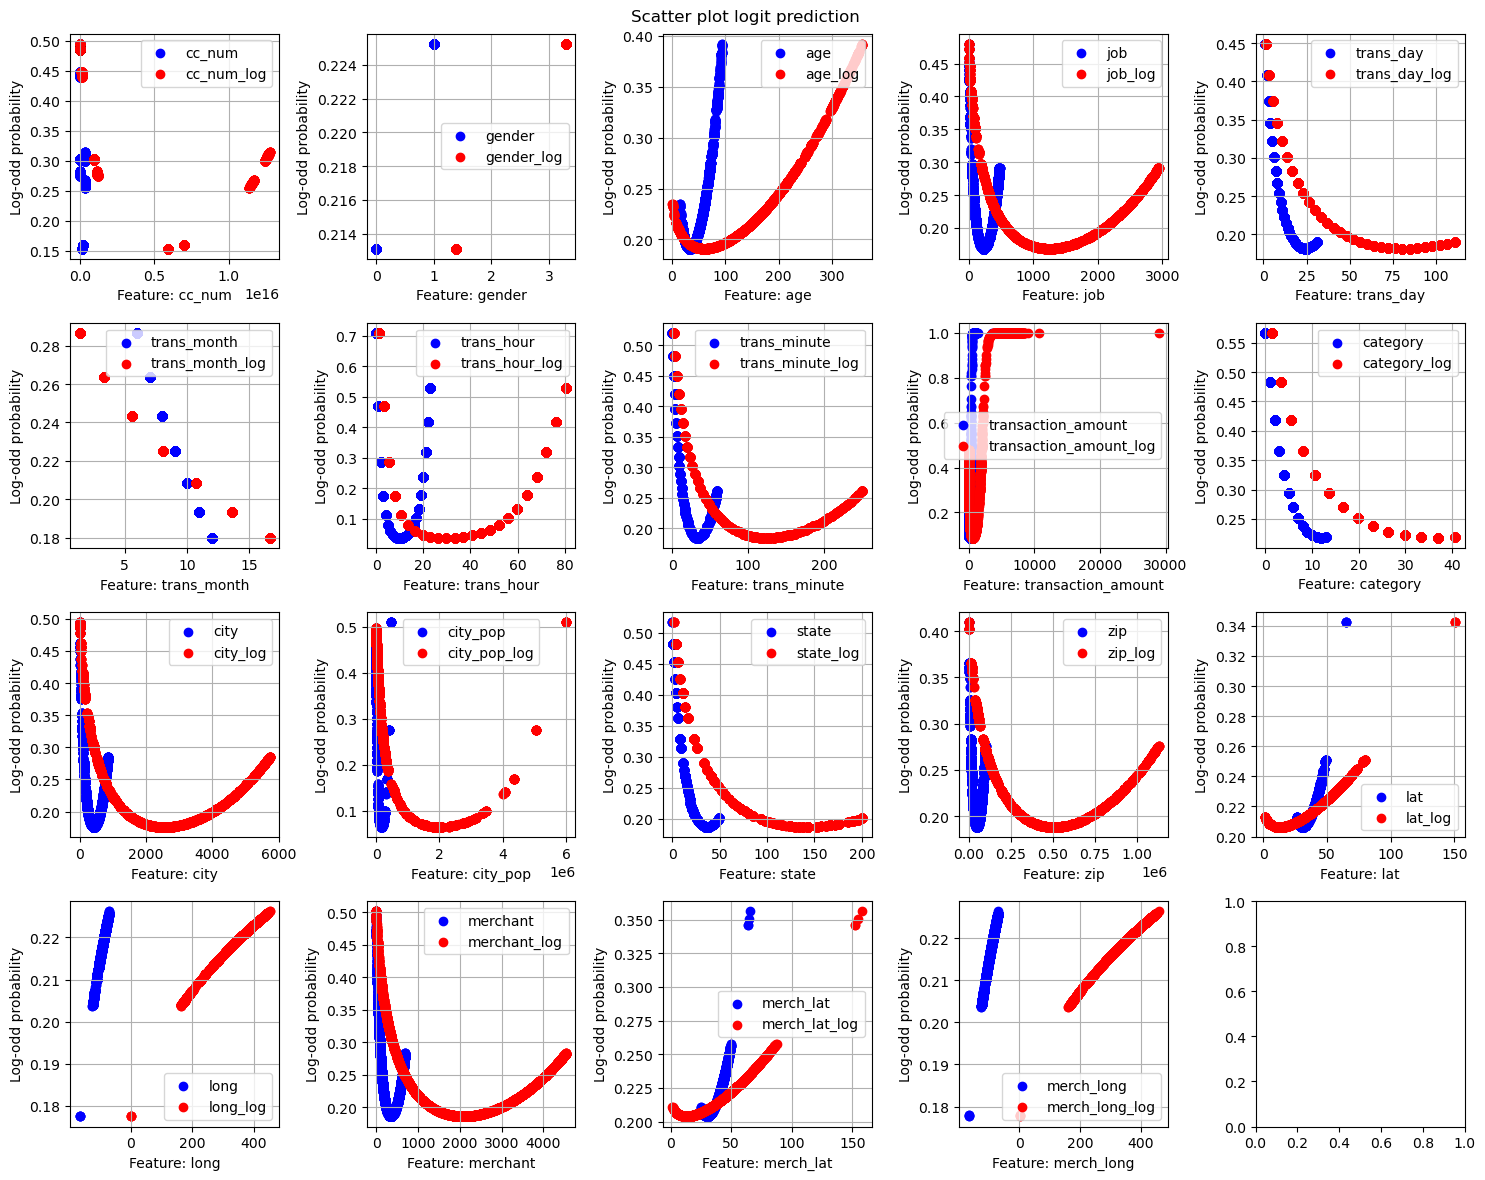

    x1 Pr>|z|  x2 Pr>|z|             Feature
0       0.000      0.000              cc_num
1       0.000      0.000              gender
2       0.000      0.000                 age
3       0.000      0.000                 job
4       0.000      0.000           trans_day
5       0.000      0.074         trans_month
6       0.000      0.000          trans_hour
7       0.000      0.000        trans_minute
8       0.000      0.000  transaction_amount
9       0.000      0.000            category
10      0.000      0.000                city
11      0.000      0.000            city_pop
12      0.000      0.000               state
13      0.000      0.000                 zip
14      0.000      0.000                 lat
15      0.000      0.000                long
16      0.000      0.000            merchant
17      0.000      0.000           merch_lat
18      0.000      0.000          merch_long


In [19]:
## Detection of nonlinearity in the data (Box-Tidwell test)

c = 0
r = 0
pr = pd.DataFrame(columns=['x1 Pr>|z|','x2 Pr>|z|','Feature'])
y_tgt = df_FraudCC_new_balanced['is_fraud']

fig, ax = plt.subplots(4,5,figsize=(15,12))

for col_idx in df_FraudCC_new_balanced.drop(columns=['trans_date','trans_year','trans_time','trans_second','is_fraud','online_purchase']):
    x     = df_FraudCC_new_balanced[col_idx]
    xlog  = (x - x.min() + 2) * np.log(x - x.min() + 2)
    Xdata   = np.column_stack((x,xlog))

    # Create logit model
    logit_model     = sm.Logit(y_tgt, Xdata).fit()

    # Obtain log-odd probabilities
    prob_pred       = logit_model.predict(Xdata)
    pval            = logit_model.pvalues
    pr.loc[len(pr)] = [pval.x1, pval.x2, col_idx]

    # Plot
    ax[r,c].scatter(x = Xdata[:,0], y = prob_pred, color='blue',label=col_idx)
    ax[r,c].scatter(x = Xdata[:,1], y = prob_pred, color='red',label=col_idx+"_log")
    ax[r,c].set_xlabel('Feature: '+col_idx)
    ax[r,c].set_ylabel('Log-odd probability')
    ax[r,c].legend(loc='best')
    ax[r,c].grid()
    
    c += 1
    if c > 4:
        r += 1
        c = 0

plt.suptitle('Scatter plot logit prediction')
plt.tight_layout()
plt.show()

# Print log-odd probabilities
print(pr)

The following feature variables will be used to build the model:

* *cc_num* (weak linear correlation, strong nonlinear relationship)
* *transaction_amount* (good linear correlation, strong nonlinear relationship)
* *category* (weak linear correlation, nonlinear relationship)
* *gender* (weak linear correlation, nonlinear relationship)
* *age* (weak linear correlation, nonlinear relationship)
* *trans_hour* (weak linear correlation, strong nonlinear relationship)
* *city_pop* (weak linear correlation, strong nonlinear relationship)
* *lat* (weak linear correlation, nonlinear relationship)
* *lon* (weak linear correlation, nonlinear relationship)
* *merch_lat* (weak linear correlation, nonlinear relationship)
* *merch_lon* (weak linear correlation, nonlinear relationship)

In [192]:
# Define features and target variable for machine learning models
features = df_FraudCC_new_balanced.columns.tolist()
features.remove('trans_date')
features.remove('trans_year')
features.remove('trans_time')
features.remove('trans_second')
features.remove('is_fraud')
features.remove('online_purchase')
features.remove('job')
features.remove('trans_day')
features.remove('trans_month')
features.remove('trans_minute')
features.remove('city')
features.remove('state')
features.remove('zip')
features.remove('merchant')
features.remove('merch_lat')
features.remove('merch_long')

data_max = data_max[features]
data_min = data_min[features]
X = df_FraudCC_new_balanced[features] # Features for machine learning models
y = df_FraudCC_new_balanced['is_fraud'] # Target variable for machine learning models

In [193]:
# Normalize the features using Min-Max scaling
X_scaled = (X - data_max)/(data_max - data_min)

# SVM model

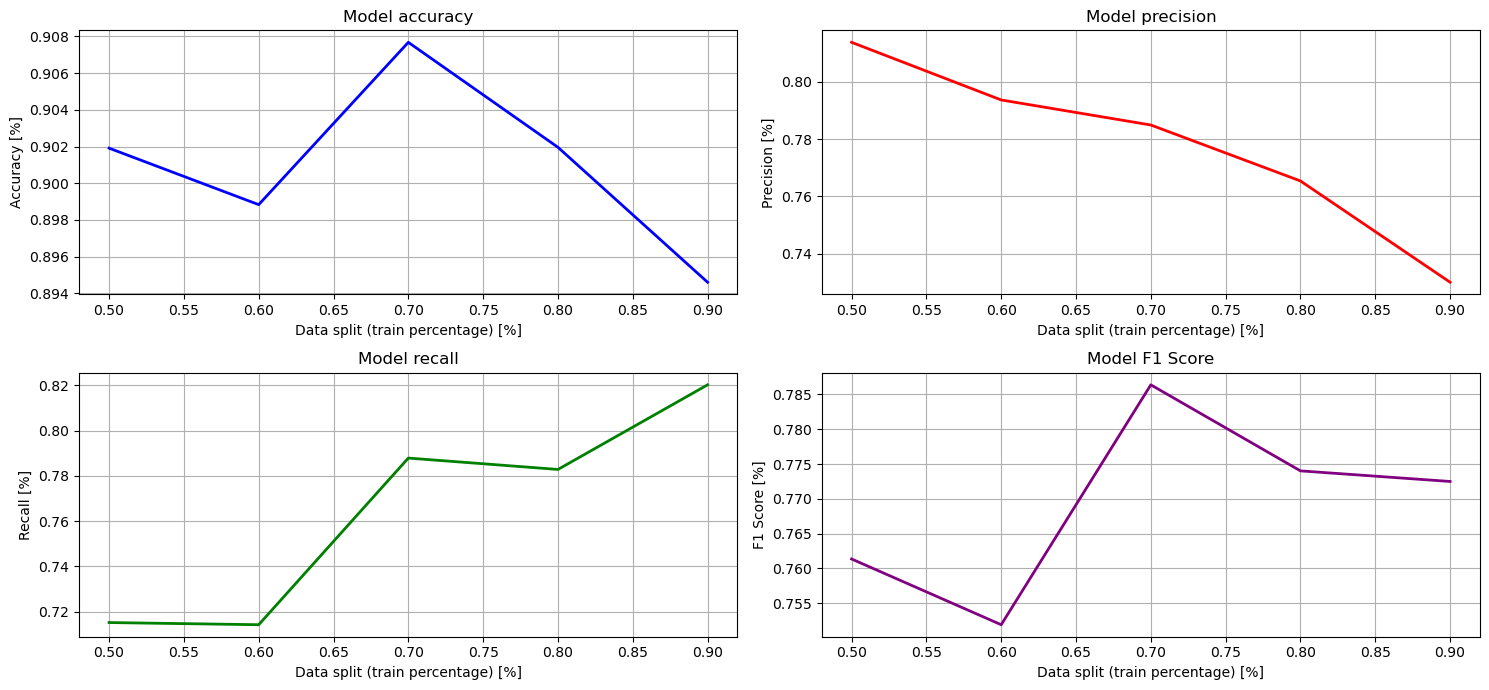

In [48]:
# Test best split trade-off we loop over different splitting ratios

accuracy_svm  = []
precision_svm = []
recall_svm    = []
f1_svm        = []


for split_ratio in np.arange(0.5,1,0.1):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 42, train_size = split_ratio)

    # Support vector machines

    fraud_model = SVC(kernel = "rbf", C = 3.0, gamma = 0.1, class_weight='balanced', probability=True)
    fraud_model.fit(X_train, y_train)

# Perform prediction
    y_pred = fraud_model.predict(X_test)

    # Compute accuracy, precision, and recall
    accuracy_svm.append(accuracy_score(y_test, y_pred))
    precision_svm.append(precision_score(y_test, y_pred, average='binary'))
    recall_svm.append(recall_score(y_test, y_pred, average='binary'))
    f1_svm.append(f1_score(y_test, y_pred, average='binary'))

# Plot split vs. scores

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=(15,7))

ax0.plot(np.arange(0.5,1,0.1),accuracy_svm,color='blue',linewidth=2)
ax0.grid()
ax0.set_xlabel("Data split (train percentage) [%]")
ax0.set_ylabel("Accuracy [%]")
ax0.set_title("Model accuracy")
ax1.plot(np.arange(0.5,1,0.1),precision_svm,color='red',linewidth=2)
ax1.grid()
ax1.set_xlabel("Data split (train percentage) [%]")
ax1.set_ylabel("Precision [%]")
ax1.set_title("Model precision")
ax2.plot(np.arange(0.5,1,0.1),recall_svm,color='green',linewidth=2)
ax2.grid()
ax2.set_xlabel("Data split (train percentage) [%]")
ax2.set_ylabel("Recall [%]")
ax2.set_title("Model recall")
ax3.plot(np.arange(0.5,1,0.1),f1_svm,color='purple',linewidth=2)
ax3.grid()
ax3.set_xlabel("Data split (train percentage) [%]")
ax3.set_ylabel("F1 Score [%]")
ax3.set_title("Model F1 Score")
plt.tight_layout()
plt.show()

In [49]:
# Train model with best split ratio

best_split_ratio = np.arange(0.5,1,0.1)[np.argmax(f1_svm)]
print(f'Best split ratio: {best_split_ratio}')
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 42, train_size = best_split_ratio)

# Support vector machines

fraud_svm_model = SVC(kernel = "rbf", C = 3, gamma = 0.1, class_weight='balanced', probability=True)
fraud_svm_model.fit(X_train, y_train)

# Perform prediction
y_pred = fraud_svm_model.predict(X_test)

Best split ratio: 0.7


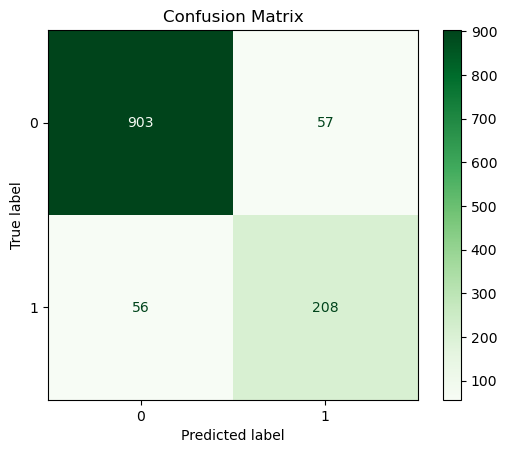

Accuracy: 0.908
Precision: 0.785
Recall: 0.788
F1 Score: 0.786


In [50]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title(f'Confusion Matrix')
plt.show()

# Scores
print(f"Accuracy: {accuracy_score(y_test,y_pred):0.3f}")
print(f"Precision: {precision_score(y_test,y_pred,average='binary'):0.3f}")
print(f"Recall: {recall_score(y_test,y_pred, average='binary'):0.3f}")
print(f"F1 Score: {f1_score(y_test,y_pred, average='binary'):0.3f}")

In [51]:
# Hyperparameter optimization using grid search

hyperparams = {
    "C": [0.5, 0.8, 1, 3, 5],
    "kernel": ['rbf', 'sigmoid'],
    "gamma": ['scale','auto',0.1, 0.5, 0.8],
    "class_weight": ['balanced'],
    "probability": [True]
}

# We initialize the grid
grid = GridSearchCV(fraud_svm_model, hyperparams, scoring = 'f1', cv = 5)
grid.fit(X_train, y_train)

# Get best parameters
print(f"Best hyperparameters: {grid.best_params_}")

# Test best hyperparameter combination

best_fraud_svm_model = SVC(**grid.best_params_)
best_fraud_svm_model.fit(X_train, y_train)
y_pred = best_fraud_svm_model.predict(X_test)

# Compute accuracy, precision, and recall
grid_accuracy_svm   = accuracy_score(y_test, y_pred)
grid_precision_svm  = precision_score(y_test, y_pred, average='binary')
grid_recall_svm     = recall_score(y_test, y_pred, average='binary')
grid_f1_svm         = f1_score(y_test, y_pred, average='binary')

print('The best SVM model to predict the fraud factor uses the following independent variables\n')
for i, col in enumerate(X.columns):
    print(f'{i+1}. {col}')
print('\n')

print(f'The SVM model after optimizing the parameters has the following performance parameters:\n')
print(f'Accuracy = {grid_accuracy_svm:0.3f}')
print(f'Precision = {grid_precision_svm:0.3f}')
print(f'Recall = {grid_recall_svm:0.3f}')
print(f'F1 Score = {grid_f1_svm:0.3f}\n')

Best hyperparameters: {'C': 5, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
The best SVM model to predict the fraud factor uses the following independent variables

1. cc_num
2. gender
3. age
4. trans_hour
5. transaction_amount
6. category
7. city_pop
8. lat
9. long


The SVM model after optimizing the parameters has the following performance parameters:

Accuracy = 0.905
Precision = 0.774
Recall = 0.792
F1 Score = 0.783



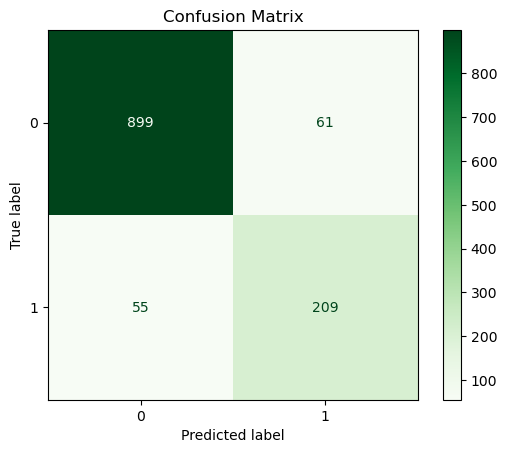

In [52]:
# Confusion matrix of the best model
cm = confusion_matrix(y_test, y_pred.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title(f'Confusion Matrix')
plt.show()

In [53]:
## Save the model
dump(best_fraud_svm_model, open("fraud_cc_svm_default_42.sav", "wb"))

# KNN model

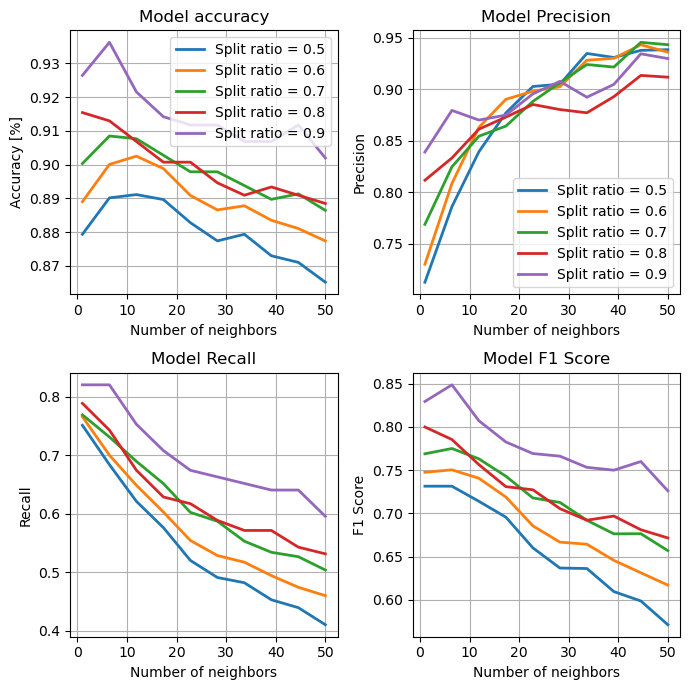

In [42]:
# Test best split trade-off we loop over different splitting ratios

k_range       = np.linspace(1, 50, 10)

fig, ax = plt.subplots(2,2,figsize=(7,7))

for split_ratio in np.arange(0.5,1,0.1):
    
    accuracy_knn  = []
    precision_knn = []
    recall_knn    = []
    f1_knn        = []

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 42, train_size = split_ratio)
    
    for k in k_range.round().astype(int):

        # K-Nearest Neighbors Classifier

        fraud_knn_model = KNeighborsClassifier(n_neighbors=k, weights='distance') 
        fraud_knn_model.fit(X_train, y_train)

        # Perform prediction
        y_pred = fraud_knn_model.predict(X_test)

        # Compute accuracy, precision, and recall
        accuracy_knn.append(accuracy_score(y_test, y_pred))
        precision_knn.append(precision_score(y_test, y_pred, average='binary'))
        recall_knn.append(recall_score(y_test, y_pred, average='binary'))
        f1_knn.append(f1_score(y_test, y_pred, average='binary'))

    # Plot split vs. scores

    ax[0,0].plot(k_range,accuracy_knn,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[0,0].grid()
    ax[0,0].set_xlabel("Number of neighbors")
    ax[0,0].set_ylabel("Accuracy [%]")
    ax[0,0].set_title("Model accuracy")
    ax[0,0].legend()

    ax[0,1].plot(k_range,precision_knn,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[0,1].grid()
    ax[0,1].set_xlabel("Number of neighbors")
    ax[0,1].set_ylabel("Precision")
    ax[0,1].set_title("Model Precision")
    ax[0,1].legend()

    ax[1,0].plot(k_range,recall_knn,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[1,0].grid()
    ax[1,0].set_xlabel("Number of neighbors")
    ax[1,0].set_ylabel("Recall")
    ax[1,0].set_title("Model Recall")

    ax[1,1].plot(k_range,f1_knn,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[1,1].grid()
    ax[1,1].set_xlabel("Number of neighbors")
    ax[1,1].set_ylabel("F1 Score")
    ax[1,1].set_title("Model F1 Score")

    plt.tight_layout()


In [44]:
# Train model with best split ratio and best number of neighbors
best_split_ratio = 0.9
best_k_neighbors = 6

print(f'Best split ratio: {best_split_ratio}')
print(f'Best number of neighbors: {best_k_neighbors}')

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 42, train_size = best_split_ratio)

# Support vector machines

fraud_knn_model = KNeighborsClassifier(n_neighbors=best_k_neighbors, weights='distance')
fraud_knn_model.fit(X_train, y_train)

# Perform prediction
y_pred = fraud_knn_model.predict(X_test)

# Compute scores

accuracy_knn   = accuracy_score(y_test, y_pred)
precision_knn  = precision_score(y_test, y_pred,average='binary')
recall_knn     = recall_score(y_test, y_pred, average='binary')
f1_knn         = f1_score(y_test, y_pred, average='binary')

Best split ratio: 0.9
Best number of neighbors: 6


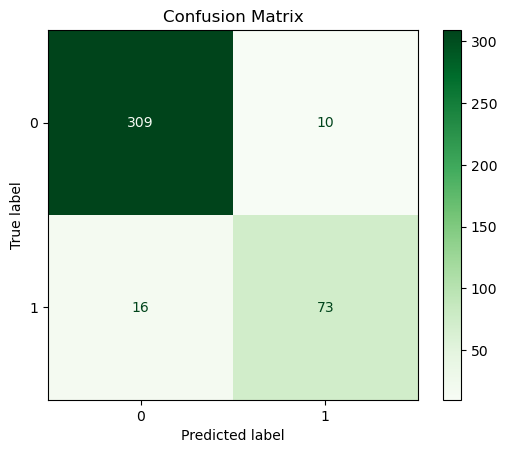

Accuracy: 0.936
Precision: 0.880
Recall: 0.820
F1 Score: 0.849


In [45]:
# Confusion matrix of the best model

cm = confusion_matrix(y_test, y_pred.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title(f'Confusion Matrix')
plt.show()

# Scores
print(f"Accuracy: {accuracy_score(y_test,y_pred):0.3f}")
print(f"Precision: {precision_score(y_test,y_pred,average='binary'):0.3f}")
print(f"Recall: {recall_score(y_test,y_pred, average='binary'):0.3f}")
print(f"F1 Score: {f1_score(y_test,y_pred, average='binary'):0.3f}")

In [46]:
# Hyperparameter optimization using grid search

hyperparams = {
    "n_neighbors": np.linspace(1, 50, 10).round().astype(int),
    "weights": ['uniform', 'distance'],
    "metric": ['euclidean', 'manhattan', 'minkowski']
    
}

# We initialize the grid
grid = GridSearchCV(fraud_knn_model, hyperparams, scoring = 'f1', cv = 5)
grid.fit(X_train, y_train)

# Get best parameters
print(f"Best hyperparameters: {grid.best_params_}")

# Test best hyperparameter combination

best_fraud_knn_model = KNeighborsClassifier(**grid.best_params_)
best_fraud_knn_model.fit(X_train, y_train)
y_pred = best_fraud_knn_model.predict(X_test)

# Compute accuracy, precision, and recall
grid_accuracy   = accuracy_score(y_test, y_pred)
grid_precision  = precision_score(y_test, y_pred, average='binary')
grid_recall     = recall_score(y_test, y_pred, average='binary')
grid_f1         = f1_score(y_test, y_pred, average='binary')

print('The best KNN model to predict the fraud factor uses the following independent variables\n')
for i, col in enumerate(X.columns):
    print(f'{i+1}. {col}')
print('\n')

print(f'The KNN model after processing the data has the following performance parameters:\n')
print(f'Accuracy = {grid_accuracy:0.3f}')
print(f'Precision = {grid_precision:0.3f}')
print(f'Recall = {grid_recall:0.3f}')
print(f'F1 Score = {grid_f1:0.3f}\n')

Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': np.int64(6), 'weights': 'distance'}
The best KNN model to predict the fraud factor uses the following independent variables

1. cc_num
2. gender
3. age
4. trans_hour
5. transaction_amount
6. category
7. city_pop
8. lat
9. long


The KNN model after processing the data has the following performance parameters:

Accuracy = 0.946
Precision = 0.885
Recall = 0.865
F1 Score = 0.875



In [47]:
## Save the model
dump(best_fraud_knn_model, open("fraud_cc_knn_default_42.sav", "wb"))

# Random forest model

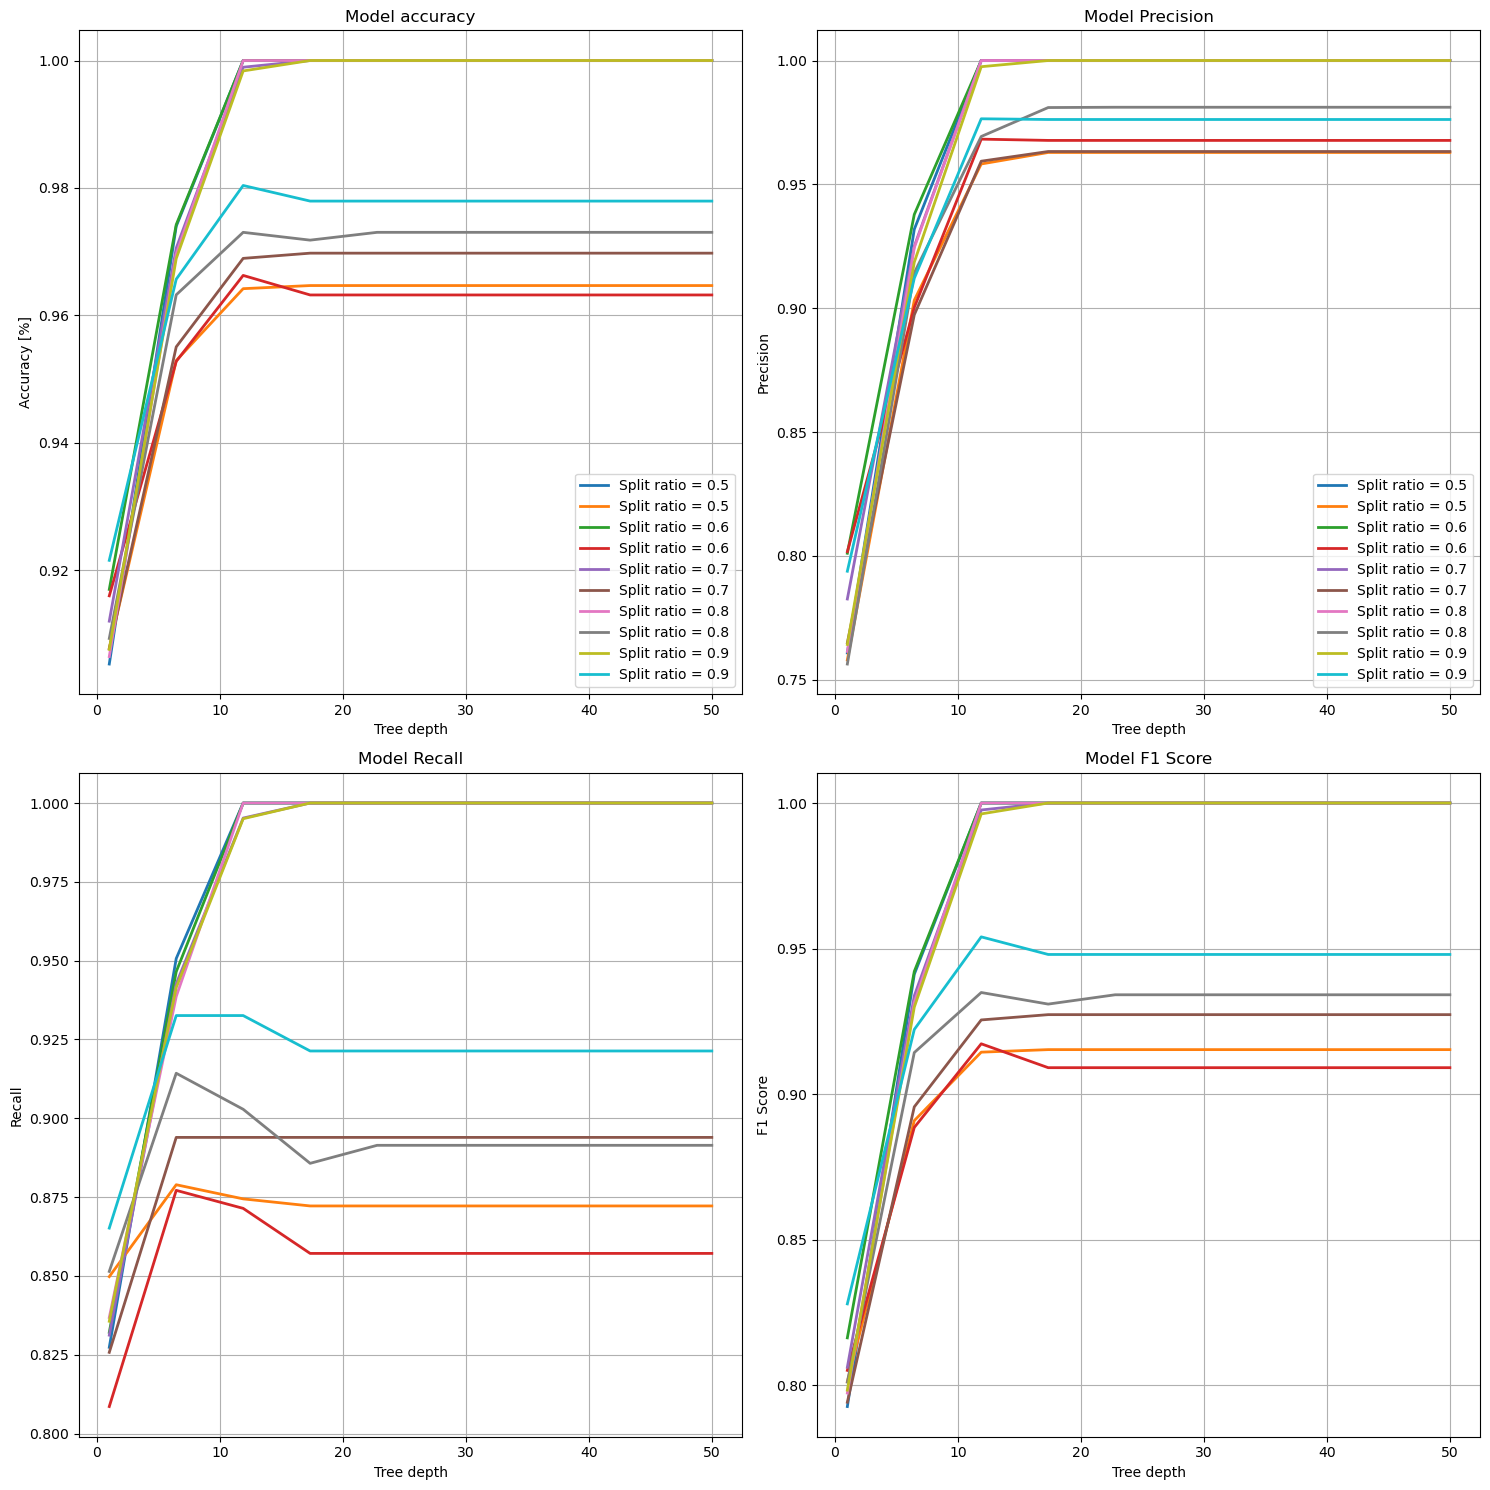

In [194]:
# Test best split trade-off we loop over different splitting ratios

tree_depth  = np.linspace(1, 50, 10)

fig, ax = plt.subplots(2,2,figsize=(15,15))

for split_ratio in np.arange(0.5,1,0.1):
    
    accuracy_forest_train  = []
    precision_forest_train = []
    recall_forest_train    = []
    f1_forest_train        = []
    accuracy_forest_test  = []
    precision_forest_test = []
    recall_forest_test    = []
    f1_forest_test        = []

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 42, train_size = split_ratio)
    
    for td in tree_depth.round().astype(int):

        # Random forest classifier

        fraud_forest_model = RandomForestClassifier(n_estimators=100, max_depth=td, random_state=42, class_weight='balanced') 
        fraud_forest_model.fit(X_train, y_train)

        # Perform prediction
        y_pred_train = fraud_forest_model.predict(X_train)
        y_pred_test  = fraud_forest_model.predict(X_test)

        # Compute accuracy, precision, and recall
        accuracy_forest_train.append(accuracy_score(y_train, y_pred_train))
        precision_forest_train.append(precision_score(y_train, y_pred_train, average='binary'))
        recall_forest_train.append(recall_score(y_train, y_pred_train, average='binary'))
        f1_forest_train.append(f1_score(y_train, y_pred_train, average='binary'))

        accuracy_forest_test.append(accuracy_score(y_test, y_pred_test))
        precision_forest_test.append(precision_score(y_test, y_pred_test, average='binary'))
        recall_forest_test.append(recall_score(y_test, y_pred_test, average='binary'))
        f1_forest_test.append(f1_score(y_test, y_pred_test, average='binary'))

    # Plot split vs. scores

    ax[0,0].plot(tree_depth,accuracy_forest_train,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[0,0].plot(tree_depth,accuracy_forest_test,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[0,0].grid()
    ax[0,0].set_xlabel("Tree depth")
    ax[0,0].set_ylabel("Accuracy [%]")
    ax[0,0].set_title("Model accuracy")
    ax[0,0].legend()

    ax[0,1].plot(tree_depth,precision_forest_train,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[0,1].plot(tree_depth,precision_forest_test,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[0,1].grid()
    ax[0,1].set_xlabel("Tree depth")
    ax[0,1].set_ylabel("Precision")
    ax[0,1].set_title("Model Precision")
    ax[0,1].legend()

    ax[1,0].plot(tree_depth,recall_forest_train,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[1,0].plot(tree_depth,recall_forest_test,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[1,0].grid()
    ax[1,0].set_xlabel("Tree depth")
    ax[1,0].set_ylabel("Recall")
    ax[1,0].set_title("Model Recall")

    ax[1,1].plot(tree_depth,f1_forest_train,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[1,1].plot(tree_depth,f1_forest_test,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[1,1].grid()
    ax[1,1].set_xlabel("Tree depth")
    ax[1,1].set_ylabel("F1 Score")
    ax[1,1].set_title("Model F1 Score")

    plt.tight_layout()

In [195]:
# Train model with best split ratio and best tree depth
best_split_ratio = 0.9
best_tree_depth  = 12

print(f'Best split ratio: {best_split_ratio}')
print(f'Best tree depth: {best_tree_depth}')

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 42, train_size = best_split_ratio)

# Support vector machines

fraud_forest_model = RandomForestClassifier(n_estimators=100, max_depth=best_tree_depth, random_state=42, class_weight='balanced') 
fraud_forest_model.fit(X_train, y_train)

# Perform prediction
y_pred = fraud_forest_model.predict(X_test)

Best split ratio: 0.9
Best tree depth: 12


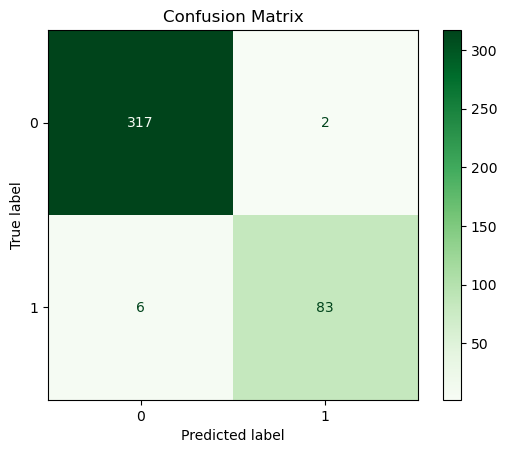

Accuracy: 0.980
Precision: 0.976
Recall: 0.933
F1 Score: 0.954


In [196]:
# Confusion matrix of the model

cm = confusion_matrix(y_test, y_pred.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title(f'Confusion Matrix')
plt.show()

# Scores
print(f"Accuracy: {accuracy_score(y_test,y_pred):0.3f}")
print(f"Precision: {precision_score(y_test,y_pred,average='binary'):0.3f}")
print(f"Recall: {recall_score(y_test,y_pred, average='binary'):0.3f}")
print(f"F1 Score: {f1_score(y_test,y_pred, average='binary'):0.3f}")

In [25]:
# Hyperparameter optimization

hyperparams = {
    "max_depth": [None, 1,  6, 12, 17, 23, 28, 34, 39, 45, 50],
    "n_estimators": [10, 20, 50, 100, 300, 500],
    "class_weight": ['balanced']
    
}

# We initialize the grid
grid = GridSearchCV(fraud_forest_model, hyperparams, scoring = 'f1', cv = 5)
grid.fit(X_train, y_train)

# Get best parameters
print(f"Best hyperparameters: {grid.best_params_}")

# Test best hyperparameter combination

best_fraud_forest_model = RandomForestClassifier(**grid.best_params_)
best_fraud_forest_model.fit(X_train, y_train)
y_pred = best_fraud_forest_model.predict(X_test)

# Compute accuracy, precision, and recall
grid_accuracy_forest   = accuracy_score(y_test, y_pred)
grid_precision_forest  = precision_score(y_test, y_pred,average='binary')
grid_recall_forest     = recall_score(y_test, y_pred, average='binary')
grid_f1_forest         = f1_score(y_test, y_pred, average='binary')

print('The best random forest model to predict fraud uses the following independent variables\n')
for i, col in enumerate(X.columns):
    print(f'{i+1}. {col}')
print('\n')

print(f'The random forest model after processing the data has the following performance parameters:\n')
print(f'Accuracy = {grid_accuracy_forest:0.3f}')
print(f'Precision = {grid_precision_forest:0.3f}')
print(f'Recall = {grid_recall_forest:0.3f}')
print(f'F1 Score = {grid_f1_forest:0.3f}\n')

Best hyperparameters: {'class_weight': 'balanced', 'max_depth': 17, 'n_estimators': 50}
The best random forest model to predict fraud uses the following independent variables

1. cc_num
2. gender
3. age
4. trans_hour
5. transaction_amount
6. category
7. city_pop
8. lat
9. long


The random forest model after processing the data has the following performance parameters:

Accuracy = 0.980
Precision = 0.976
Recall = 0.933
F1 Score = 0.954



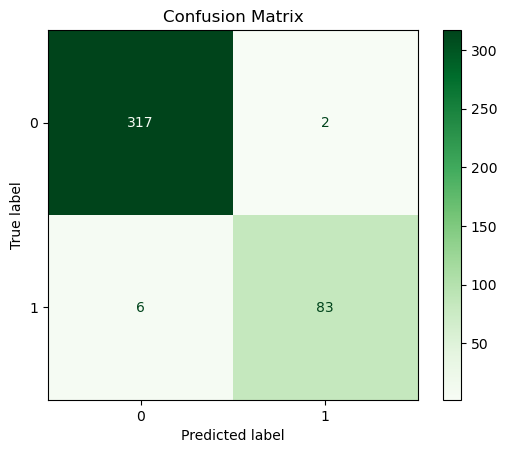

In [26]:
# Confusion matrix of the best model
cm = confusion_matrix(y_test, y_pred.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title(f'Confusion Matrix')
plt.show()

In [27]:
## Save the model
dump(best_fraud_forest_model, open("fraud_cc_forest_default_42.sav", "wb"))

# XGBoost model

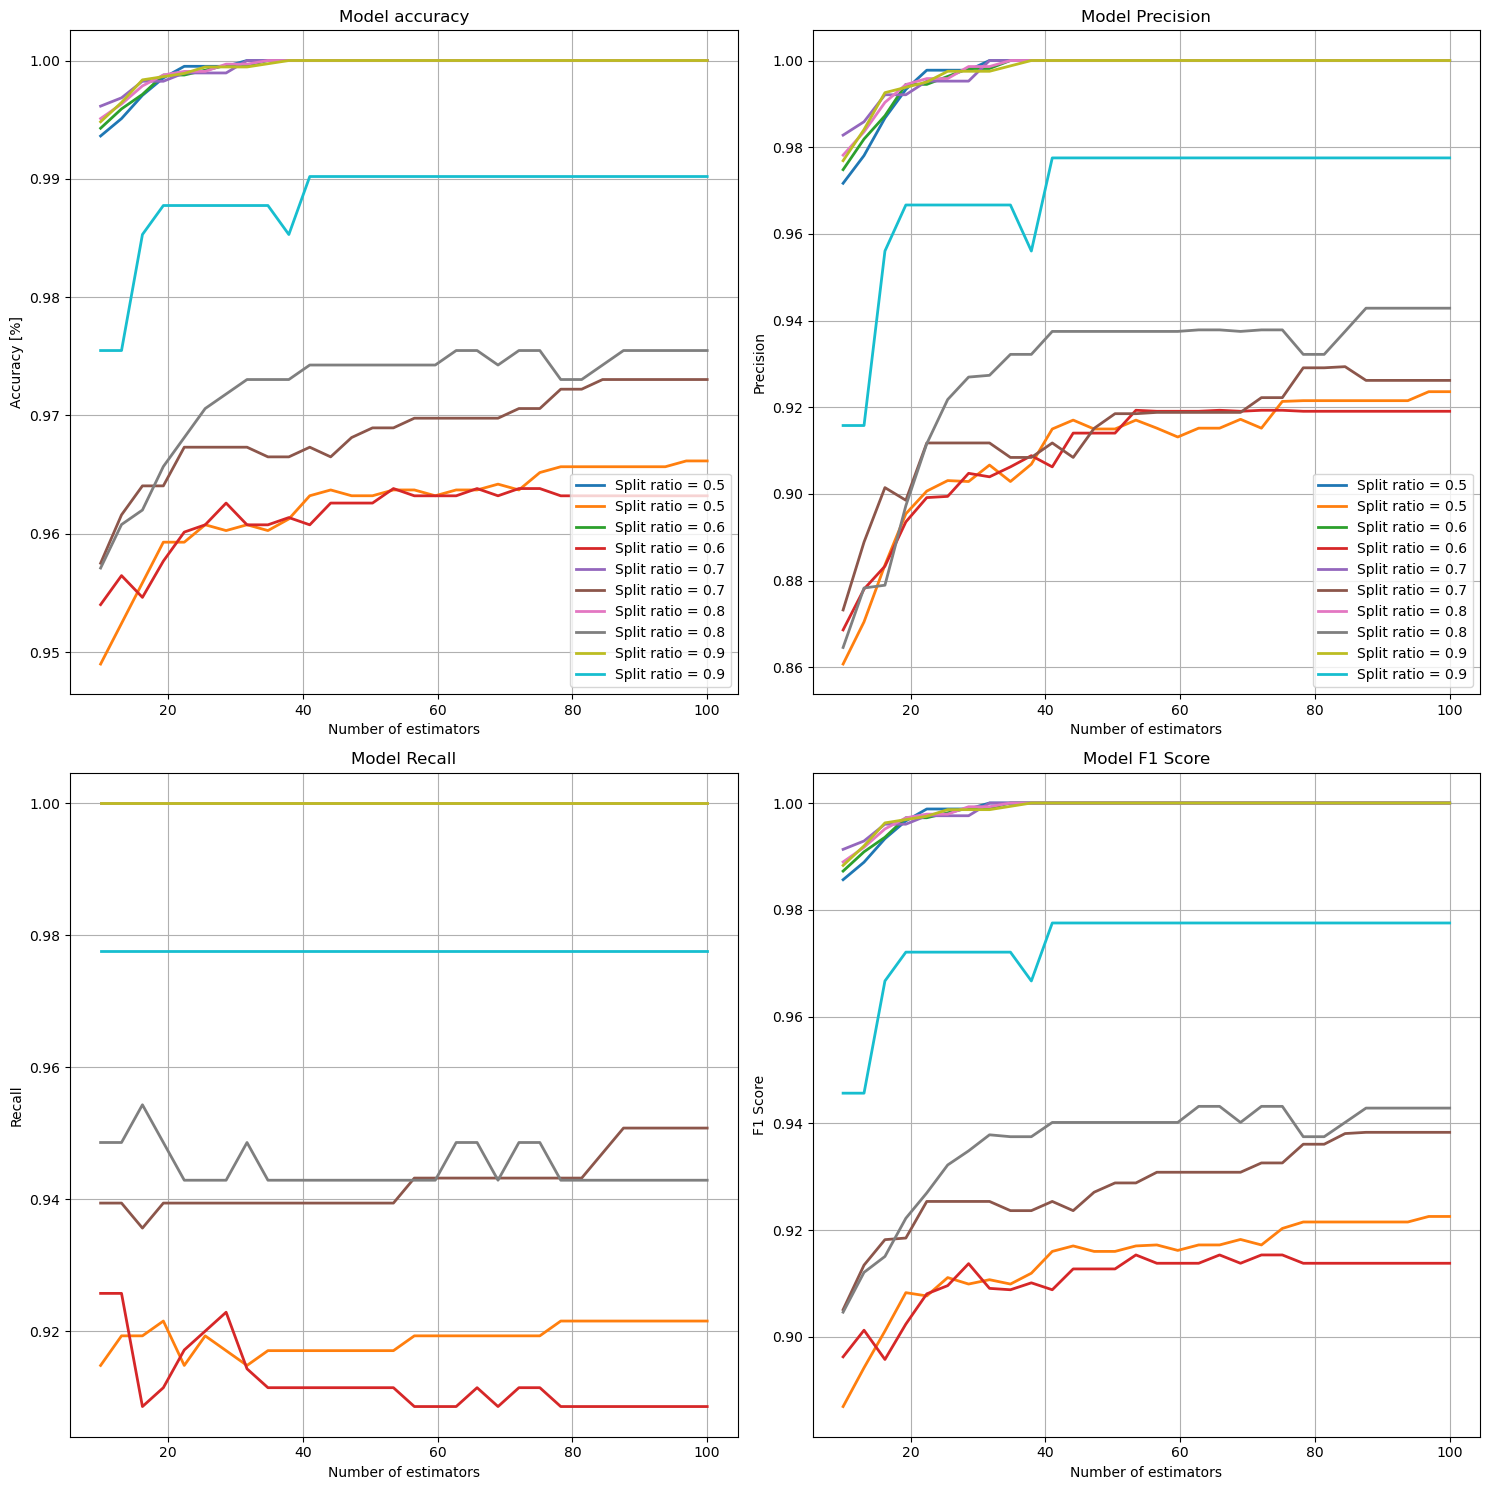

In [30]:
# Test best split trade-off we loop over different splitting ratios

nest    = np.linspace(10, 100, 30)

fig, ax = plt.subplots(2,2,figsize=(15,15))

for split_ratio in np.arange(0.5,1,0.1):
    
    accuracy_xgb_train  = []
    precision_xgb_train = []
    recall_xgb_train    = []
    f1_xgb_train        = []
    accuracy_xgb_test  = []
    precision_xgb_test = []
    recall_xgb_test    = []
    f1_xgb_test        = []

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 42, train_size = split_ratio)
    
    for nidx in nest.round().astype(int):

        # XGBoost classifier

        fraud_xgb_model = XGBClassifier(n_estimators=nidx, max_depth=17, scale_pos_weight=9) 
        fraud_xgb_model.fit(X_train, y_train)

        # Perform prediction
        y_pred_train = fraud_xgb_model.predict(X_train)
        y_pred_test  = fraud_xgb_model.predict(X_test)

        # Compute accuracy, precision, and recall
        accuracy_xgb_train.append(accuracy_score(y_train, y_pred_train))
        precision_xgb_train.append(precision_score(y_train, y_pred_train, average='binary'))
        recall_xgb_train.append(recall_score(y_train, y_pred_train, average='binary'))
        f1_xgb_train.append(f1_score(y_train, y_pred_train, average='binary'))

        accuracy_xgb_test.append(accuracy_score(y_test, y_pred_test))
        precision_xgb_test.append(precision_score(y_test, y_pred_test, average='binary'))
        recall_xgb_test.append(recall_score(y_test, y_pred_test, average='binary'))
        f1_xgb_test.append(f1_score(y_test, y_pred_test, average='binary'))

    # Plot split vs. scores

    ax[0,0].plot(nest,accuracy_xgb_train,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[0,0].plot(nest,accuracy_xgb_test,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[0,0].grid()
    ax[0,0].set_xlabel("Number of estimators")
    ax[0,0].set_ylabel("Accuracy [%]")
    ax[0,0].set_title("Model accuracy")
    ax[0,0].legend()

    ax[0,1].plot(nest,precision_xgb_train,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[0,1].plot(nest,precision_xgb_test,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[0,1].grid()
    ax[0,1].set_xlabel("Number of estimators")
    ax[0,1].set_ylabel("Precision")
    ax[0,1].set_title("Model Precision")
    ax[0,1].legend()

    ax[1,0].plot(nest,recall_xgb_train,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[1,0].plot(nest,recall_xgb_test,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[1,0].grid()
    ax[1,0].set_xlabel("Number of estimators")
    ax[1,0].set_ylabel("Recall")
    ax[1,0].set_title("Model Recall")

    ax[1,1].plot(nest,f1_xgb_train,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[1,1].plot(nest,f1_xgb_test,linewidth=2,label=f"Split ratio = {split_ratio:.1f}")
    ax[1,1].grid()
    ax[1,1].set_xlabel("Number of estimators")
    ax[1,1].set_ylabel("F1 Score")
    ax[1,1].set_title("Model F1 Score")

    plt.tight_layout()

In [32]:
# Train model with best split ratio and best tree depth
best_split_ratio = 0.9
best_nest        = 19

print(f'Best split ratio: {best_split_ratio}')
print(f'Best number of estimators: {best_nest}')

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 42, train_size = best_split_ratio)

# Support vector machines

fraud_xgb_model = XGBClassifier(n_estimators=nidx, max_depth=17, scale_pos_weight=9) 
fraud_xgb_model.fit(X_train, y_train)

# Perform prediction
y_pred = fraud_xgb_model.predict(X_test)

Best split ratio: 0.9
Best number of estimators: 19


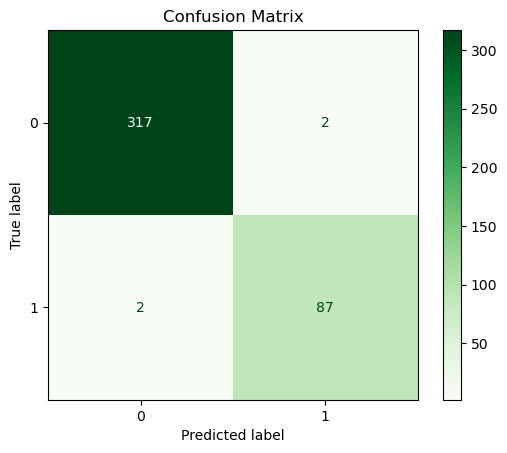

Accuracy: 0.990
Precision: 0.978
Recall: 0.978
F1 Score: 0.978


In [33]:
# Confusion matrix of the model

cm = confusion_matrix(y_test, y_pred.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title(f'Confusion Matrix')
plt.show()

# Scores
print(f"Accuracy: {accuracy_score(y_test,y_pred):0.3f}")
print(f"Precision: {precision_score(y_test,y_pred,average='binary'):0.3f}")
print(f"Recall: {recall_score(y_test,y_pred, average='binary'):0.3f}")
print(f"F1 Score: {f1_score(y_test,y_pred, average='binary'):0.3f}")

In [34]:
# Hyperparameter optimization

hyperparams = {
    "max_depth": [None, 1,  6, 12, 17, 23, 28, 34, 39, 45, 50],
    "n_estimators": [10, 20, 50, 100, 300, 500],
    "learning_rate": [0.3, 0.5, 0.8, 1],
    "scale_pos_weight": [9]
    
}

# We initialize the grid
grid = GridSearchCV(fraud_xgb_model, hyperparams, scoring = 'f1', cv = 5)
grid.fit(X_train, y_train)

# Get best parameters
print(f"Best hyperparameters: {grid.best_params_}")

# Test best hyperparameter combination

best_fraud_xgb_model = XGBClassifier(**grid.best_params_)
best_fraud_xgb_model.fit(X_train, y_train)
y_pred = best_fraud_xgb_model.predict(X_test)

# Compute accuracy, precision, and recall
grid_accuracy_xgb   = accuracy_score(y_test, y_pred)
grid_precision_xgb  = precision_score(y_test, y_pred,average='binary')
grid_recall_xgb    = recall_score(y_test, y_pred, average='binary')
grid_f1_xgb         = f1_score(y_test, y_pred, average='binary')

print('The best gradient boosted model to predict fraud uses the following independent variables\n')
for i, col in enumerate(X.columns):
    print(f'{i+1}. {col}')
print('\n')

print(f'The gradient boosted model after processing the data has the following performance parameters:\n')
print(f'Accuracy = {grid_accuracy_xgb:0.3f}')
print(f'Precision = {grid_precision_xgb:0.3f}')
print(f'Recall = {grid_recall_xgb:0.3f}')
print(f'F1 Score = {grid_f1_xgb:0.3f}\n')

Best hyperparameters: {'learning_rate': 0.5, 'max_depth': None, 'n_estimators': 300, 'scale_pos_weight': 9}
The best gradient boosted model to predict fraud uses the following independent variables

1. cc_num
2. gender
3. age
4. trans_hour
5. transaction_amount
6. category
7. city_pop
8. lat
9. long


The gradient boosted model after processing the data has the following performance parameters:

Accuracy = 0.990
Precision = 0.978
Recall = 0.978
F1 Score = 0.978



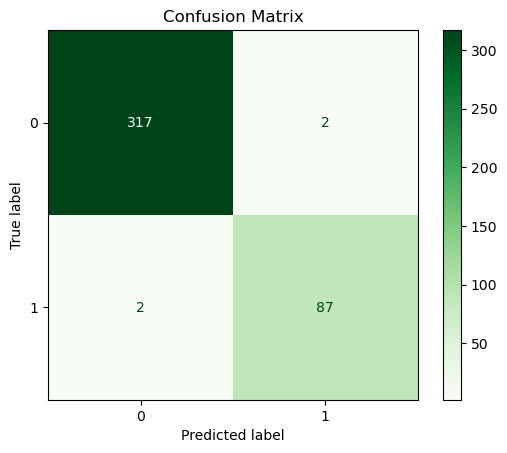

In [35]:
# Confusion matrix of the best model
cm = confusion_matrix(y_test, y_pred.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title(f'Confusion Matrix')
plt.show()

In [36]:
## Save the model
dump(best_fraud_xgb_model, open("fraud_cc_xgb_default_42.sav", "wb"))

# Stacked model

In [38]:
# Stacking models

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 42, train_size = 0.9)

# Stacking
fraud_model_stacked = StackingClassifier(
    estimators=[('best_fraud_xgb_model', best_fraud_xgb_model)],
    final_estimator= best_fraud_forest_model
)

fraud_model_stacked.fit(X_train, y_train)
y_pred = fraud_model_stacked.predict(X_test)

accuracy_stacked = accuracy_score(y_test, y_pred)
precision_stacked = precision_score(y_test, y_pred,average='binary')
recall_stacked = recall_score(y_test, y_pred,average='binary')
f1_stacked = f1_score(y_test, y_pred,average='binary')

print(f'The accuracy score of the stacked model is: {accuracy_stacked:0.3f}')
print(f'The precision score of the stacked model is: {precision_stacked:0.3f}')
print(f'The recall score of the stacked model is: {recall_stacked:0.3f}')
print(f'The F1 score of the stacked model is: {f1_stacked:0.3f}')

The accuracy score of the stacked model is: 0.988
The precision score of the stacked model is: 0.967
The recall score of the stacked model is: 0.978
The F1 score of the stacked model is: 0.972


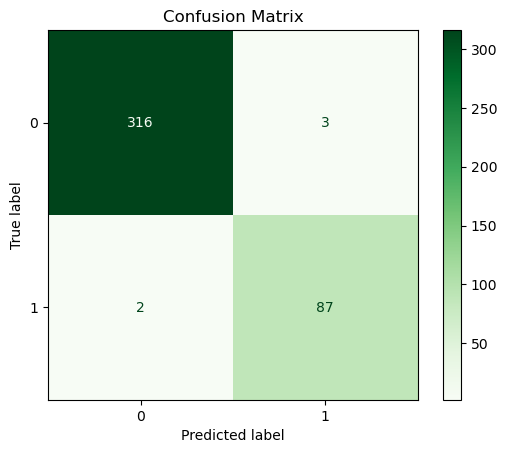

Accuracy: 0.988
Precision: 0.967
Recall: 0.978
F1 Score: 0.972

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       319
           1       0.97      0.98      0.97        89

    accuracy                           0.99       408
   macro avg       0.98      0.98      0.98       408
weighted avg       0.99      0.99      0.99       408



In [39]:
# Confusion matrix of the best model

cm = confusion_matrix(y_test, y_pred.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title(f'Confusion Matrix')
plt.show()

# Scores
print(f"Accuracy: {accuracy_score(y_test,y_pred):0.3f}")
print(f"Precision: {precision_score(y_test,y_pred,average='binary'):0.3f}")
print(f"Recall: {recall_score(y_test,y_pred, average='binary'):0.3f}")
print(f"F1 Score: {f1_score(y_test,y_pred, average='binary'):0.3f}\n")

print(classification_report(y_test,y_pred.round()))

In [40]:
## Save stacked model
dump(fraud_model_stacked, open("fraud_cc_stacked_default_42.sav", "wb"))

# Evaluation of performance of models

In [28]:
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 42, train_size = 0.9)

with open("/Users/csmb/Documents/Bootcamp Data Science & Machine Learning/Python files/Data Science and Machine Learning - 4Geeks/24 - ML Final Project/models/fraud_cc_forest_default_42.sav","rb") as rf:
    best_fraud_forest_model = load(rf)

#best_fraud_forest_model.fit(X_train, y_train)
y_pred = best_fraud_forest_model.predict(X_test)

# Compute accuracy, precision, and recall
grid_accuracy_forest   = accuracy_score(y_test, y_pred)
grid_precision_forest  = precision_score(y_test, y_pred,average='binary')
grid_recall_forest     = recall_score(y_test, y_pred, average='binary')
grid_f1_forest         = f1_score(y_test, y_pred, average='binary')

with open("/Users/csmb/Documents/Bootcamp Data Science & Machine Learning/Python files/Data Science and Machine Learning - 4Geeks/24 - ML Final Project/models/fraud_cc_knn_default_42.sav","rb") as knn:
    best_fraud_knn_model = load(knn)

#best_fraud_knn_model.fit(X_train, y_train)
y_pred = best_fraud_knn_model.predict(X_test)

# Compute accuracy, precision, and recall
accuracy_knn   = accuracy_score(y_test, y_pred)
precision_knn  = precision_score(y_test, y_pred, average='binary')
recall_knn     = recall_score(y_test, y_pred, average='binary')
f1_knn        = f1_score(y_test, y_pred, average='binary')

with open("/Users/csmb/Documents/Bootcamp Data Science & Machine Learning/Python files/Data Science and Machine Learning - 4Geeks/24 - ML Final Project/models/fraud_cc_stacked_default_42.sav","rb") as st:
    fraud_model_stacked = load(st)

#fraud_model_stacked.fit(X_train, y_train)
y_pred = fraud_model_stacked.predict(X_test)

accuracy_stacked = accuracy_score(y_test, y_pred)
precision_stacked = precision_score(y_test, y_pred,average='binary')
recall_stacked = recall_score(y_test, y_pred,average='binary')
f1_stacked = f1_score(y_test, y_pred,average='binary')

with open("/Users/csmb/Documents/Bootcamp Data Science & Machine Learning/Python files/Data Science and Machine Learning - 4Geeks/24 - ML Final Project/models/fraud_cc_svm_default_42.sav","rb") as sv:
    best_fraud_svm_model = load(sv)

#best_fraud_svm_model.fit(X_train, y_train)
y_pred = best_fraud_svm_model.predict(X_test)

# Compute accuracy, precision, and recall
grid_accuracy_svm   = accuracy_score(y_test, y_pred)
grid_precision_svm  = precision_score(y_test, y_pred, average='binary')
grid_recall_svm     = recall_score(y_test, y_pred, average='binary')
grid_f1_svm         = f1_score(y_test, y_pred, average='binary')
    

with open("/Users/csmb/Documents/Bootcamp Data Science & Machine Learning/Python files/Data Science and Machine Learning - 4Geeks/24 - ML Final Project/models/fraud_cc_xgb_default_42.sav","rb") as xg:
    best_fraud_xgb_model = load(xg)   

#best_fraud_xgb_model.fit(X_train, y_train)
y_pred = best_fraud_xgb_model.predict(X_test)

# Compute accuracy, precision, and recall
grid_accuracy_xgb   = accuracy_score(y_test, y_pred)
grid_precision_xgb  = precision_score(y_test, y_pred,average='binary')
grid_recall_xgb    = recall_score(y_test, y_pred, average='binary')
grid_f1_xgb         = f1_score(y_test, y_pred, average='binary')          

Text(0.5, 1.0, 'Precision-Recall Curves of Different Models')

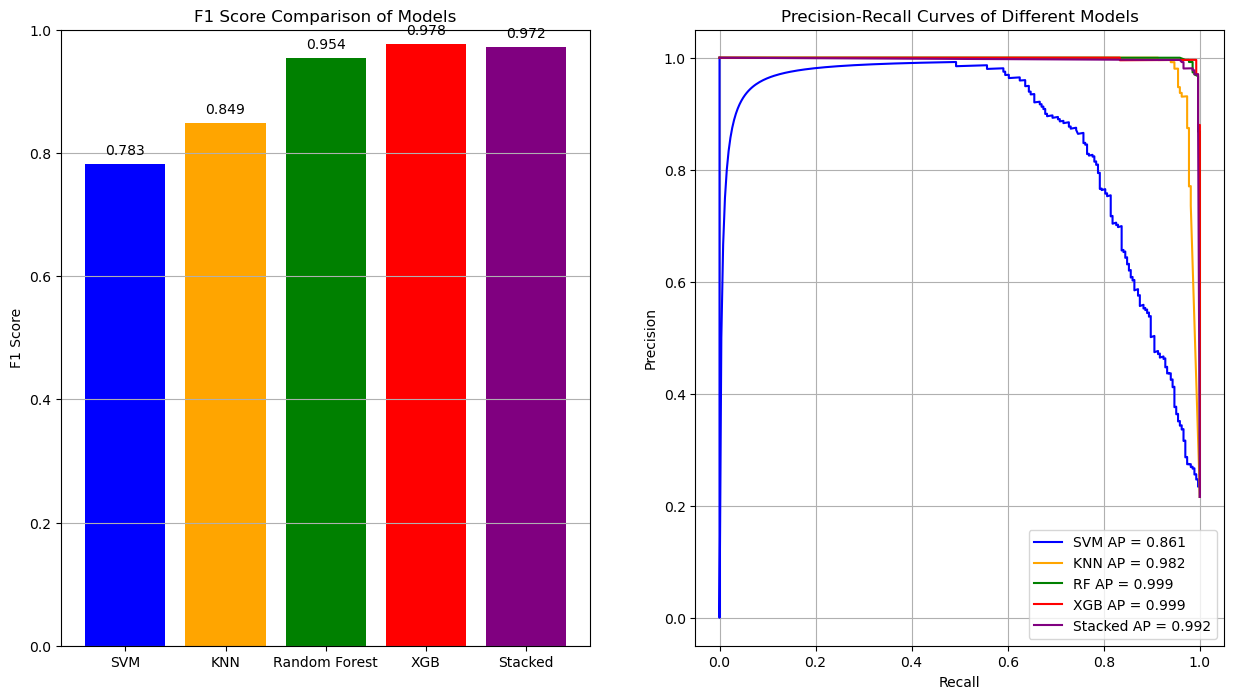

In [54]:
# Plots to assess performance

fig, ax = plt.subplots(1,2,figsize=(15,8))

# Barplot of f1 scores of the different models
model_names = ['SVM', 'KNN', 'Random Forest', 'XGB', 'Stacked']
f1_scores = [grid_f1_svm, f1_knn, grid_f1_forest, grid_f1_xgb, f1_stacked]
bars = ax[0].bar(model_names, f1_scores, color=['blue', 'orange', 'green', 'red', 'purple'])
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('F1 Score')
ax[0].set_title('F1 Score Comparison of Models')
ax[0].grid(axis='y')
for bar in bars:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

# Plot precision-recall curve of the different models
y_score_svm = best_fraud_svm_model.predict_proba(X_test)[:,1]
prec_svm, rec_svm, thresholds_svm = precision_recall_curve(y_test, y_score_svm)
ap_svm = average_precision_score(y_test, y_score_svm)
y_score_knn = best_fraud_knn_model.predict_proba(X_test)[:,1]
prec_knn, rec_knn, thresholds_knn = precision_recall_curve(y_test, y_score_knn)
ap_knn = average_precision_score(y_test, y_score_knn)
y_score_forest = best_fraud_forest_model.predict_proba(X_test)[:,1]
prec_rf, rec_rf, thresholds_rf = precision_recall_curve(y_test, y_score_forest)
ap_rf = average_precision_score(y_test, y_score_forest)
y_score_xgb = best_fraud_xgb_model.predict_proba(X_test)[:,1]
prec_xgb, rec_xgb, thresholds_xgb = precision_recall_curve(y_test, y_score_xgb)
ap_xgb = average_precision_score(y_test, y_score_xgb)
y_score_stacked = fraud_model_stacked.predict_proba(X_test)[:,1]
prec_stacked, rec_stacked, thresholds_stacked = precision_recall_curve(y_test, y_score_stacked)
ap_stacked = average_precision_score(y_test, y_score_stacked)

ax[1].plot(rec_svm, prec_svm, label=f'SVM AP = {ap_svm:.3f}', color='blue')
ax[1].plot(rec_knn, prec_knn, label=f'KNN AP = {ap_knn:.3f}', color='orange')
ax[1].plot(rec_rf, prec_rf, label=f'RF AP = {ap_rf:.3f}', color='green')
ax[1].plot(rec_xgb, prec_xgb, label=f'XGB AP = {ap_xgb:.3f}', color='red')
ax[1].plot(rec_stacked, prec_stacked, label=f'Stacked AP = {ap_stacked:.3f}', color='purple')
ax[1].grid()
ax[1].legend(loc='lower right')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curves of Different Models')

# Robustness test

In [171]:
# Testing models with excluded elements from balancing

# Get new balanced dataset with different random selection of non-fraudulent transactions
indices0_remain = list(set(indices0) - set(indices0_model)) # Remaining data to test robustness
indices1_robust = list(set(indices1) - set(indices1_model)) # Remaining data to test robustness

n0_robust = int(0.1*len(indices0_remain)) # Select 10% of the remaining non-fraudulent transactions to create a new balanced dataset 
                                          # (this corresponds to a 96%-4% split between non-fraudulent and fraudulent transactions)

indices0_robust      = rnd.sample(indices0_remain, n0_robust)
indices_robust_total = np.concatenate((indices0_robust, indices1_robust))
indices_robust_total.sort()
df_FraudCC_new_balanced_other = df_FraudCC_new_reduced.loc[indices_robust_total].copy().reset_index(drop=True)
df_FraudCC_new_balanced_other['is_fraud'].value_counts()

is_fraud
0    54542
1      108
Name: count, dtype: int64

In [172]:
# Define new features and target variable for machine learning models

# Select dataset

data_unseen         = df_FraudCC_new_balanced_other # Unseen data
data_trainval_bal   = df_FraudCC_new_balanced # Balanced data used for training and validation
data_original       = df_FraudCC_new_reduced  # Unseen and seen data

dataset = data_trainval_bal

##### Optional: Test category in isolation
cat_isolation = True
cat_val = 1 # 0 (non-fraud) or 1 (fraud)
if cat_isolation:
    X_robust = dataset[dataset['is_fraud'] == cat_val]
    X_robust = X_robust[features]
else:
    X_robust = dataset[features]

#####
choice = rnd.randint(0,len(X_robust))
X_robust = X_robust.iloc[[choice]]
y_robust = dataset['is_fraud']
y_robust = y_robust.loc[X_robust.index]

# Normalize the features using Min-Max scaling
X_robust_scaled = scaler.transform(X_robust)

print(choice)

107


In [ ]:
'''
with open('fraud_cc_svm_default_42.sav', 'rb') as file:
    best_fraud_svm_model = load(file)

with open('fraud_cc_knn_default_42.sav', 'rb') as file:
    best_fraud_knn_model = load(file)

with open('fraud_cc_forest_default_42.sav', 'rb') as file:
    best_fraud_forest_model = load(file)

with open('fraud_cc_xgb_default_42.sav', 'rb') as file:
    best_fraud_xgb_model = load(file)

with open('fraud_cc_stacked_default_42.sav', 'rb') as file:
    fraud_model_stacked = load(file)
'''

In [173]:
# Test SVM model
y_pred_svm_robust = best_fraud_svm_model.predict(X_robust_scaled)
accuracy_svm_robust = accuracy_score(y_robust, y_pred_svm_robust)
precision_svm_robust = precision_score(y_robust, y_pred_svm_robust, average='binary')
recall_svm_robust = recall_score(y_robust, y_pred_svm_robust, average='binary')
f1_svm_robust = f1_score(y_robust, y_pred_svm_robust, average='binary')

# Test KNN model
y_pred_knn_robust = best_fraud_knn_model.predict(X_robust_scaled)
accuracy_knn_robust = accuracy_score(y_robust, y_pred_knn_robust)
precision_knn_robust = precision_score(y_robust, y_pred_knn_robust, average='binary')
recall_knn_robust = recall_score(y_robust, y_pred_knn_robust, average='binary')
f1_knn_robust = f1_score(y_robust, y_pred_knn_robust, average='binary')

# Test Random Forest model
y_pred_forest_robust = best_fraud_forest_model.predict(X_robust_scaled)
accuracy_forest_robust = accuracy_score(y_robust, y_pred_forest_robust)
precision_forest_robust = precision_score(y_robust, y_pred_forest_robust, average='binary')
recall_forest_robust = recall_score(y_robust, y_pred_forest_robust, average='binary')
f1_forest_robust = f1_score(y_robust, y_pred_forest_robust, average='binary')

# Test XGB model
y_pred_xgb_robust = best_fraud_xgb_model.predict(X_robust_scaled)
accuracy_xgb_robust = accuracy_score(y_robust, y_pred_xgb_robust)
precision_xgb_robust = precision_score(y_robust, y_pred_xgb_robust, average='binary')
recall_xgb_robust = recall_score(y_robust, y_pred_xgb_robust, average='binary')
f1_xgb_robust = f1_score(y_robust, y_pred_xgb_robust, average='binary')

# Test Stacked model
y_pred_stacked_robust = fraud_model_stacked.predict(X_robust_scaled)
accuracy_stacked_robust = accuracy_score(y_robust, y_pred_stacked_robust)
precision_stacked_robust = precision_score(y_robust, y_pred_stacked_robust, average='binary')
recall_stacked_robust = recall_score(y_robust, y_pred_stacked_robust, average='binary')
f1_stacked_robust = f1_score(y_robust, y_pred_stacked_robust, average='binary')

# Print table with classification scores of the different models on the robust data
results_robust = pd.DataFrame({
    'Model': ['SVM', 'KNN', 'RF', 'XGB', 'Stacked'],
    'Accuracy': [accuracy_svm_robust, accuracy_knn_robust, accuracy_forest_robust, accuracy_xgb_robust, accuracy_stacked_robust],
    'Precision': [precision_svm_robust, precision_knn_robust, precision_forest_robust, precision_xgb_robust, precision_stacked_robust],
    'Recall': [recall_svm_robust, recall_knn_robust, recall_forest_robust, recall_xgb_robust, recall_stacked_robust],
    'F1 Score': [f1_svm_robust, f1_knn_robust, f1_forest_robust, f1_xgb_robust, f1_stacked_robust]
})
print(results_robust)

     Model  Accuracy  Precision  Recall  F1 Score
0      SVM     1.000      1.000   1.000     1.000
1      KNN     1.000      1.000   1.000     1.000
2       RF     1.000      1.000   1.000     1.000
3      XGB     1.000      1.000   1.000     1.000
4  Stacked     1.000      1.000   1.000     1.000


In [154]:
features = df_FraudCC_new_balanced.columns.tolist()
features.remove('trans_date')
features.remove('trans_year')
features.remove('trans_time')
features.remove('trans_second')
features.remove('online_purchase')
features.remove('job')
features.remove('trans_day')
#features.remove('trans_month')
features.remove('trans_minute')
#features.remove('city')
#features.remove('state')
features.remove('zip')
features.remove('merch_lat')
features.remove('merch_long')

X = df_FraudCC_new_balanced[features]

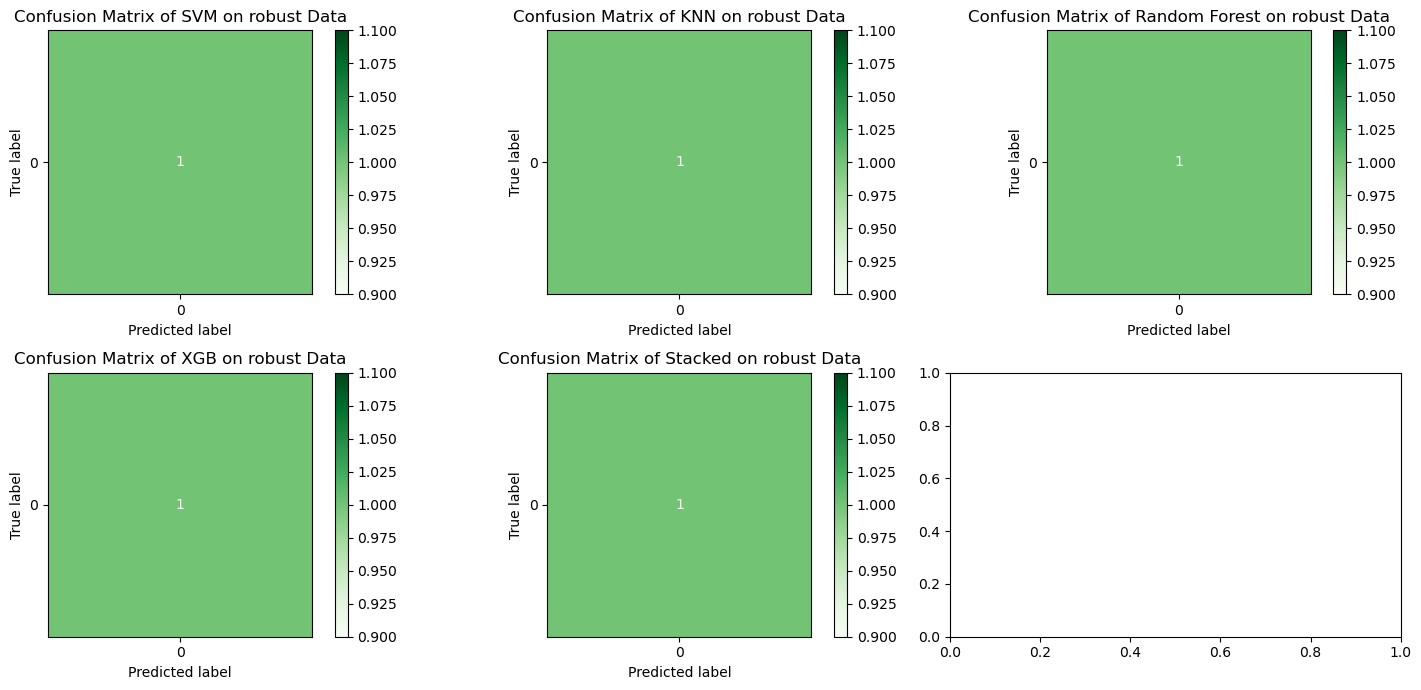

In [77]:
# Plot confusion matrix of all models on robust data

fig, ax = plt.subplots(2,3,figsize=(15,7))
models = ['SVM', 'KNN', 'Random Forest', 'XGB','Stacked']
y_preds_robust = [y_pred_svm_robust, y_pred_knn_robust, y_pred_forest_robust, y_pred_xgb_robust, y_pred_stacked_robust]
r = 0
c = 0
for i, model in enumerate(models):
    cm = confusion_matrix(y_robust, y_preds_robust[i].round())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Greens, ax=ax[r,c])
    ax[r,c].set_title(f'Confusion Matrix of {model} on robust Data')
    c += 1
    if c > 2:
        r += 1
        c = 0
plt.tight_layout()
plt.show()

The best model is XGB, followed by a stacked model containing XGB and Random Forest, then Random Forest, then KNN, and lastly SVM

# Fraud type model

In [179]:
# Define features and target variable for machine learning models
features = df_FraudCC_new_balanced.columns.tolist()
features.remove('trans_date')
features.remove('trans_year')
features.remove('trans_time')
features.remove('trans_second')
features.remove('online_purchase')
features.remove('job')
features.remove('trans_day')
#features.remove('trans_month')
features.remove('trans_minute')
#features.remove('city')
#features.remove('state')
features.remove('zip')
features.remove('merch_lat')
features.remove('merch_long')

X = df_FraudCC_new_balanced[['category','is_fraud']]
#X = X.drop(columns='category')
y = df_FraudCC_new_balanced['online_purchase']

X = X[X['is_fraud'] != 0]
y = y.loc[X.index]

#X_scaled = scaler.fit_transform(X)
X_scaled = (X - X.min())/(X.max() - X.min())
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, train_size=0.8)

# Weigh unbalanced data

w = compute_sample_weight(
    class_weight='balanced',
    y=y_train 
)

# XGBClassifier

fraud_type_xgb_model = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss',n_estimators = 100, max_depth = 6, learning_rate = 0.5)
fraud_type_xgb_model.fit(X_train,y_train, sample_weight = w)
y_pred = fraud_type_xgb_model.predict(X_test)

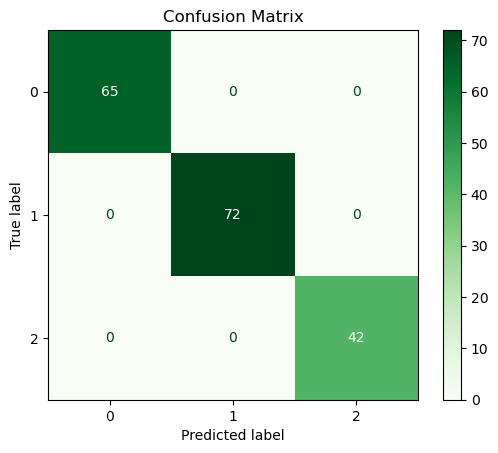

Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 Score: 1.000


In [180]:
# Confusion matrix of the model

cm = confusion_matrix(y_test, y_pred.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title(f'Confusion Matrix')
plt.show()

# Scores
print(f"Accuracy: {accuracy_score(y_test,y_pred):0.3f}")
print(f"Precision: {precision_score(y_test,y_pred,average='macro'):0.3f}")
print(f"Recall: {recall_score(y_test,y_pred, average='macro'):0.3f}")
print(f"F1 Score: {f1_score(y_test,y_pred, average='macro'):0.3f}")

In [ ]:
# Hyperparameter optimization

hyperparams = {
    "max_depth": [None, 1,  6, 12, 17, 23, 28, 34, 39, 45, 50],
    "n_estimators": [10, 20, 50, 100, 300, 500],
    "learning_rate": [0.3, 0.5, 0.8, 1],
    "objective": ['multi:softprob'],
    "eval_metric": ['mlogloss']
    
}

# We initialize the grid
grid = GridSearchCV(fraud_type_xgb_model, hyperparams, scoring = 'f1_macro', cv = 5)
grid.fit(X_train, y_train)

# Get best parameters
print(f"Best hyperparameters: {grid.best_params_}")

# Test best hyperparameter combination

best_fraud_type_xgb_model = XGBClassifier(**grid.best_params_)
best_fraud_type_xgb_model.fit(X_train, y_train, sample_weight=w)
y_pred = best_fraud_type_xgb_model.predict(X_test)

# Compute accuracy, precision, and recall
grid_accuracy_type_xgb   = accuracy_score(y_test, y_pred)
grid_precision_type_xgb  = precision_score(y_test, y_pred,average='macro')
grid_recall_type_xgb    = recall_score(y_test, y_pred, average='macro')
grid_f1_type_xgb         = f1_score(y_test, y_pred, average='macro')

print('The best gradient boosted model to predict fraud uses the following independent variables\n')
for i, col in enumerate(X.columns):
    print(f'{i+1}. {col}')
print('\n')

print(f'The gradient boosted model after processing the data has the following performance parameters:\n')
print(f'Accuracy = {grid_accuracy_type_xgb:0.3f}')
print(f'Precision = {grid_precision_type_xgb:0.3f}')
print(f'Recall = {grid_recall_type_xgb:0.3f}')
print(f'F1 Score = {grid_f1_type_xgb:0.3f}\n')

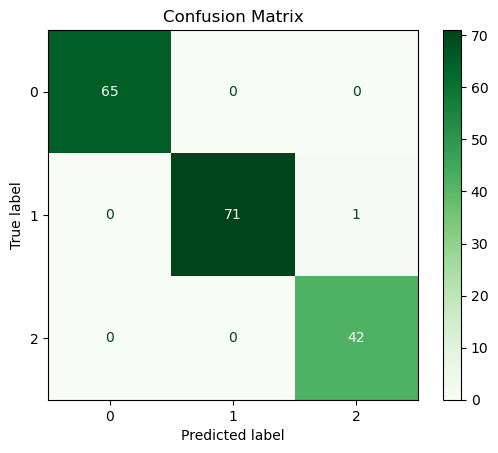

In [166]:
# Confusion matrix of the model

cm = confusion_matrix(y_test, y_pred.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title(f'Confusion Matrix')
plt.show()

In [181]:
## Save the type model
dump(fraud_type_xgb_model, open("fraud_type_xgb_default_42.sav", "wb"))